In [1]:
import os
import sys
import glob
import random
import warnings
import shutil
from distutils.dir_util import copy_tree


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
# from keras.layers.merge import concatenate
from keras.layers import concatenate

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
from tensorflow.keras.metrics import Metric

import skimage.io

import sklearn.metrics

In [2]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

In [3]:
# the small set for experimentation!
TEST_PATH = './FORmodels/testset_raw/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Get train and test IDs
test_ids = next(os.walk(TEST_PATH))[1]
len(test_ids)
test_ids.remove('.DS_S')

In [4]:
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
Y_test.shape

/var/folders/qr/np1v1r_53zqc4t2j9qztcrxh0000gn/T/ipykernel_8565/2543807963.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)


(67, 128, 128)

In [5]:
# Get and resize train images and masks
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    pather = TEST_PATH + id_    
    img = imread(pather + '/images/' + id_ + '.png')
    X_test[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        
    pattern = pather+'/masks/*'
    for fname in glob.glob(pattern, recursive=True):

        mask_ = imread(fname)     
        mask_ = resize(mask_,(IMG_HEIGHT, IMG_WIDTH, 1))
#         mask_ = np.expand_dims(mask_, axis=1)        
        mask = np.maximum(mask, mask_)
        
    Y_test[n] = mask

Getting and resizing train images and masks ... 


/var/folders/qr/np1v1r_53zqc4t2j9qztcrxh0000gn/T/ipykernel_8565/1601769784.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  0%|                                                    | 0/67 [00:00<?, ?it/s]/var/folders/qr/np1v1r_53zqc4t2j9qztcrxh0000gn/T/ipykernel_8565/1601769784.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https:

44 ed4b8e0d756836be7acb2e2b7799c473b52424e3092a71d3c6d23558e500dc4c


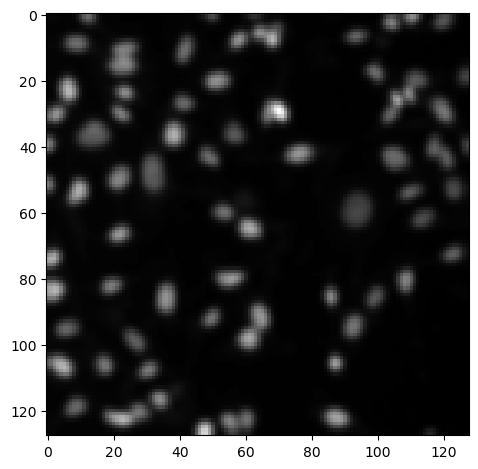

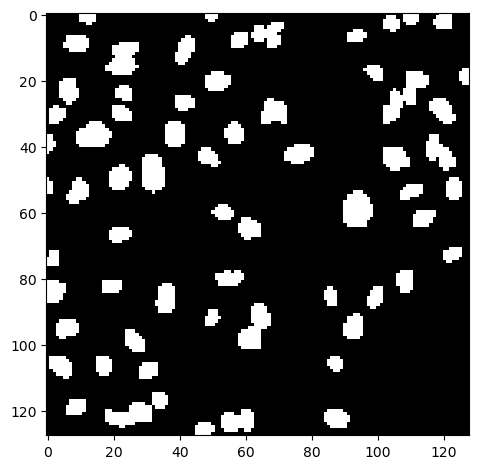

In [6]:
# Check if training data looks all right
# DOUBLE CHECK MASKS!!
ix = random.randint(0, len(test_ids))

print(ix, test_ids[ix])
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(Y_test[ix]))
plt.show()

In [7]:
# loading UNET
# Predict on train, val and test
unetep0 = load_model('model-UNetEp=0Model_20230330.h5', custom_objects={'binary_io_u': [tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3)]})
unetep0.trainable = False

unetep2 = load_model('model-UNetEp=2Model_20230330.h5', custom_objects={'binary_io_u': [tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3)]})
unetep2.trainable = False

unetep50 = load_model('model-UNetEp=50Model_20230330.h5', custom_objects={'binary_io_u': [tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3)]})
unetep50.trainable = False

unetepVAR = load_model('model-UNetEp=VARModel_20230330.h5', custom_objects={'binary_io_u': [tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3)]})
unetepVAR.trainable = False

unetep2_05 = load_model('model-UNetEp=2(0.5)Model_20230330.h5', custom_objects={'binary_io_u': [tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3)]})
unetep2_05.trainable = False


# # loading FCN
# Predict on train, val and test
fcnep0 = load_model('model-FCNEp=0Model_20230330.h5', custom_objects={'binary_io_u': [tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3)]})
fcnep0.trainable = False

fcnep2 = load_model('model-FCNEp=2Model_20230330.h5', custom_objects={'binary_io_u': [tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3)]})
fcnep2.trainable = False

fcnep50 = load_model('model-FCNEp=50Model_20230330.h5', custom_objects={'binary_io_u': [tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3)]})
fcnep50.trainable = False

fcnepVAR = load_model('model-FCNEp=VARModel_20230330.h5', custom_objects={'binary_io_u': [tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3)]})
fcnepVAR.trainable = False

fcnep2_05 = load_model('model-UNetEp=2(0.5)Model_20230330.h5', custom_objects={'binary_io_u': [tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3)]})
fcnep2_05.trainable = False


2023-04-04 10:29:55.326984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
## ADDING ADVERSARIAL ATTACK...
loss_object = tf.keras.losses.BinaryCrossentropy()

def create_adversarial_pattern(input_image, input_label, modelling):
    input_image = tf.convert_to_tensor(np.reshape(input_image, (-1, 128, 128, 1)), dtype=tf.float32)
    input_label = np.reshape(input_label, (-1, 128, 128, 1))

#     Record operations for automatic differentiation??
    with tf.GradientTape() as tape:

        tape.watch(input_image)
        prediction = modelling(input_image)
        
        loss = loss_object(input_label, prediction)

#   # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)

    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [9]:
# building out a function to automate this!

def addingpert (model):
    lol = []
    for i in range(len(X_test)):
        lol.append(create_adversarial_pattern(X_test[i],Y_test[i], model))
        
    return lol

In [10]:
pertunet_ep0 = addingpert(unetep0)
pertunet_ep2 = addingpert(unetep2)
pertunet_ep50 = addingpert(unetep50)
pertunet_epVAR = addingpert(unetepVAR)
pertunet_ep2_05 = addingpert(unetep2_05)

pertfcn_ep0 = addingpert(fcnep0)
pertfcn_ep2 = addingpert(fcnep2)
pertfcn_ep50 = addingpert(fcnep50)
pertfcn_epVAR = addingpert(fcnepVAR)
pertfcn_ep2_05 = addingpert(fcnep2_05)


In [11]:
# not variable amounts--> very specific amounts of perturbation

def addingep (ep, pert):
    newtest = []

    for i in range(len(X_test)): 
        pert[i] = tf.reshape(pert[i], [1, 128, 128])
        new = X_test[i] + ep* pert[i] * 0.5 + 0.5
        newtest.append(np.squeeze(new.numpy()))

    newtest = np.asarray(newtest)
    newtest = np.squeeze(newtest)
    
    return newtest

In [12]:
def auto_addingep (pert):
    at0 = addingep(0, pert)
    at2 = addingep(2, pert)
    at5 = addingep(5, pert)
    at10 = addingep(10, pert)
    at25 = addingep(25, pert)
    at50 = addingep(50, pert)
    
    return [at0, at2, at5, at10, at25, at50 ]


In [13]:
newtest_unet_ep0 = auto_addingep(pertunet_ep0)
newtest_unet_ep2 = auto_addingep(pertunet_ep2)
newtest_unet_ep50 = auto_addingep(pertunet_ep50)
newtest_unet_epVAR = auto_addingep(pertunet_epVAR)
newtest_unet_ep2_05 = auto_addingep(pertunet_ep2_05)

newtest_fcn_ep0 = auto_addingep(pertfcn_ep0)
newtest_fcn_ep2 = auto_addingep(pertfcn_ep2)
newtest_fcn_ep50 = auto_addingep(pertfcn_ep50)
newtest_fcn_epVAR = auto_addingep(pertfcn_epVAR)
newtest_fcn_ep2_05 = auto_addingep(pertfcn_ep2_05)

In [130]:
X_test[0]

array([[77, 78, 80, ..., 15, 31, 40],
       [78, 78, 80, ..., 14, 28, 37],
       [78, 78, 80, ..., 12, 25, 31],
       ...,
       [ 6,  6,  6, ...,  2,  2,  2],
       [ 6,  6,  6, ...,  2,  2,  0],
       [ 6,  6,  6, ...,  0,  0,  0]], dtype=uint8)

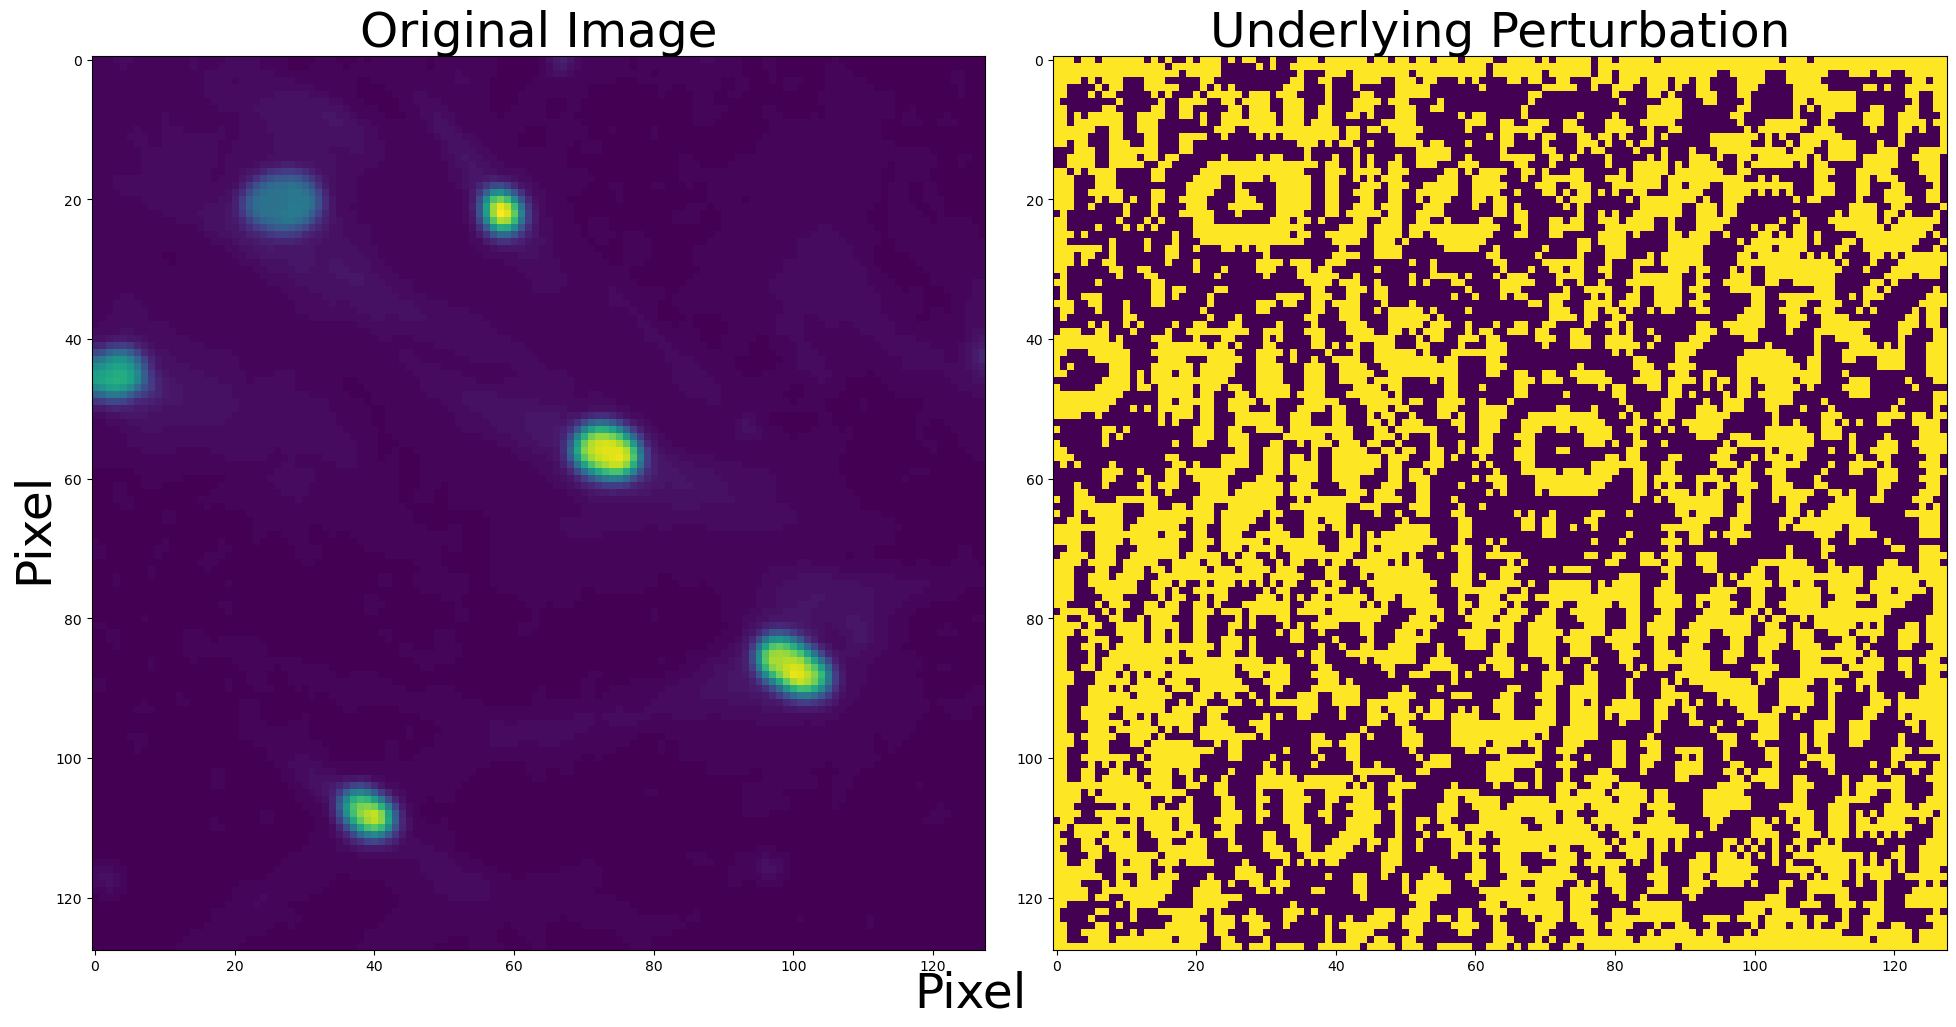

In [187]:
# Adding a plot to show off the diff perturbations..

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))



ax1.set_title('Original Image', fontsize=35)
ax1.imshow(X_test[2])

ax2.set_title('Underlying Perturbation', fontsize=35)
ax2.imshow(np.squeeze(pertunet_ep0[2]))

fig.supxlabel('Pixel', fontsize=35)
fig.supylabel('Pixel', fontsize=35 )

fig.tight_layout()
plt.savefig('PerturbationImpact.png', bbox_inches='tight')

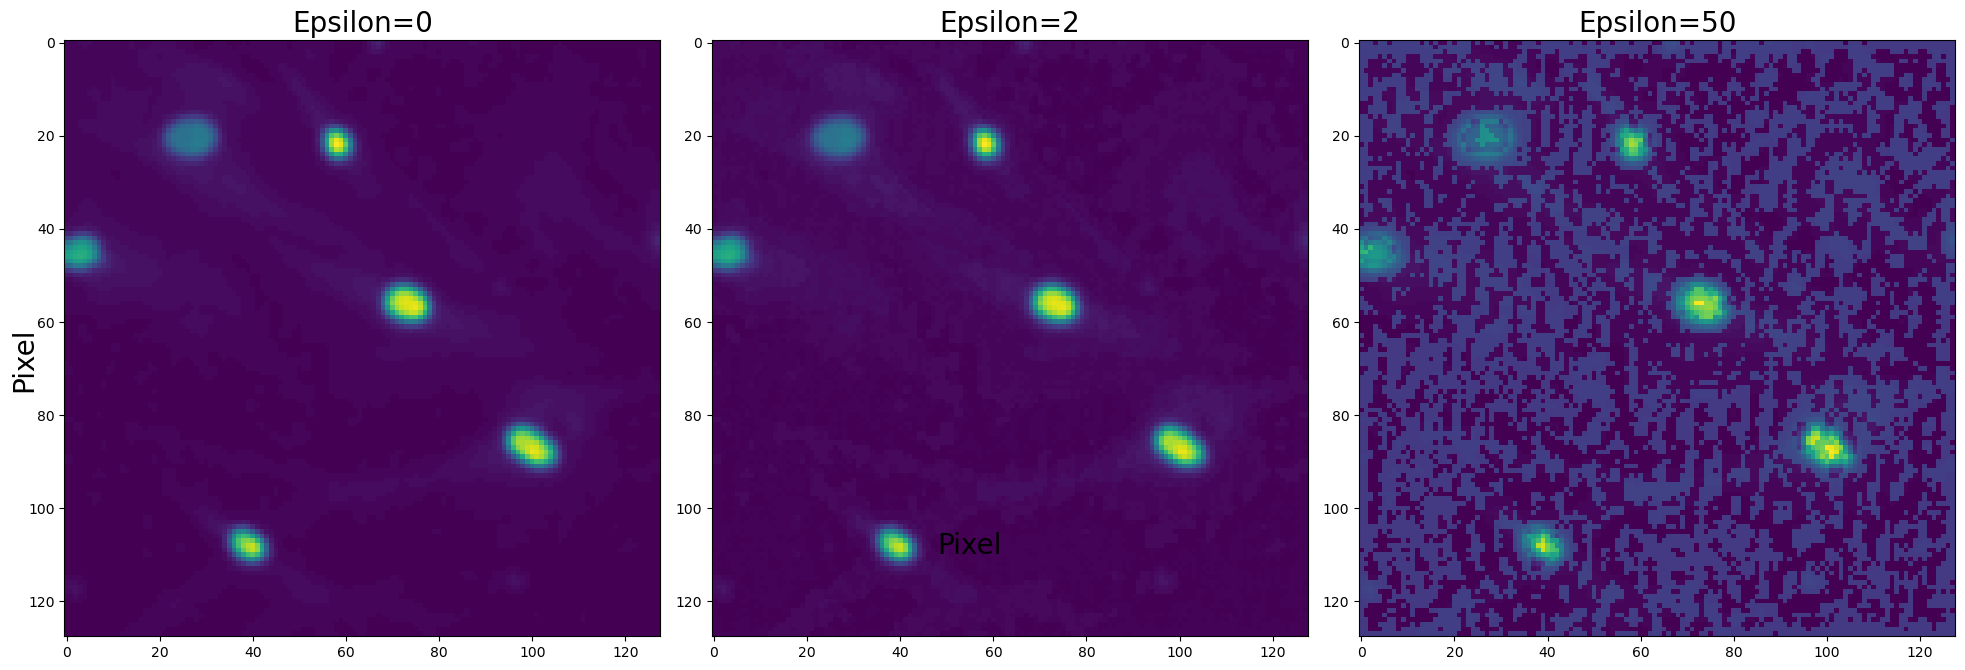

In [252]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

ax1.set_title('Epsilon=0', fontsize=20)
ax1.imshow(np.squeeze(newtest_unet_ep0[0][2]))

ax2.set_title('Epsilon=2', fontsize=20)
ax2.imshow(np.squeeze(newtest_unet_ep0[1][2]))

ax3.set_title('Epsilon=50', fontsize=20)
ax3.imshow(np.squeeze(newtest_unet_ep0[5][2]))

# fig.suptitle('Varying Epsilon', y=.75, fontsize=25)
fig.supxlabel('Pixel', y=.3, fontsize=20)
fig.supylabel('Pixel', fontsize=20)

fig.tight_layout()

plt.savefig('VaryingTrainingEp.png', bbox_inches='tight')

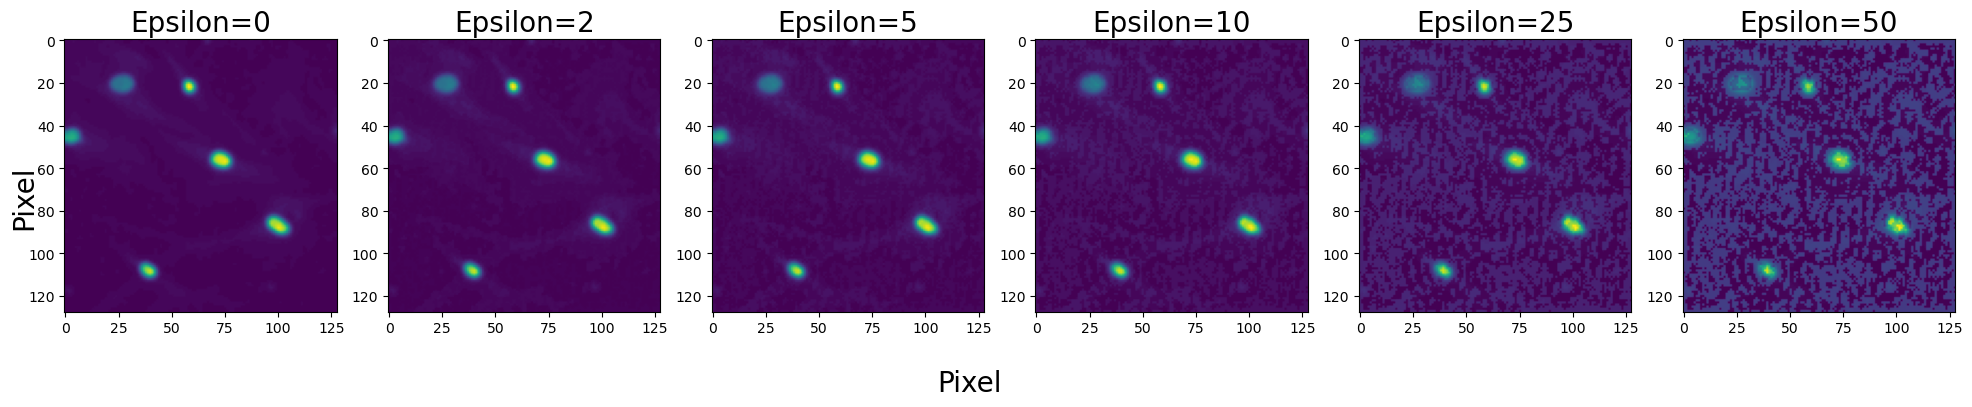

In [186]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20, 10))

ax1.set_title('Epsilon=0', fontsize=20)
ax1.imshow(np.squeeze(newtest_unet_ep0[0][2]))

ax2.set_title('Epsilon=2', fontsize=20)
ax2.imshow(np.squeeze(newtest_unet_ep0[1][2]))

ax3.set_title('Epsilon=5', fontsize=20)
ax3.imshow(np.squeeze(newtest_unet_ep0[2][2]))

ax4.set_title('Epsilon=10', fontsize=20)
ax4.imshow(np.squeeze(newtest_unet_ep0[3][2]))

ax5.set_title('Epsilon=25', fontsize=20)
ax5.imshow(np.squeeze(newtest_unet_ep0[4][2]))

ax6.set_title('Epsilon=50', fontsize=20)
ax6.imshow(np.squeeze(newtest_unet_ep0[5][2]))

# fig.suptitle('Varying Epsilon', y=.75, fontsize=25)
fig.supxlabel('Pixel', y=.3, fontsize=20)
fig.supylabel('Pixel', fontsize=20)

fig.tight_layout()

plt.savefig('VaryingEp.png', bbox_inches='tight')

In [153]:
def gen_preds (model, newx):
    with0 = model.predict(newx[0], verbose=1)
    with2 = model.predict(newx[1], verbose=1)
    with5 = model.predict(newx[2], verbose=1)
    with10 = model.predict(newx[3], verbose=1)
    with25 = model.predict(newx[4], verbose=1)
    with50 = model.predict(newx[5], verbose=1)
    
    return [with0, with2, with5, with10, with25, with50]

In [154]:
unetep0_preds = gen_preds(unetep0, newtest_unet_ep0)
unetep2_preds = gen_preds(unetep2, newtest_unet_ep2)
unetep50_preds = gen_preds(unetep50, newtest_unet_ep50)
unetepVAR_preds = gen_preds(unetepVAR, newtest_unet_epVAR)
unetep2_05_preds = gen_preds(unetep2_05, newtest_unet_ep2_05)

fcnep0_preds = gen_preds(fcnep0, newtest_fcn_ep0)
fcnep2_preds = gen_preds(fcnep2, newtest_fcn_ep2)
fcnep50_preds = gen_preds(fcnep50, newtest_fcn_ep50)
fcnepVAR_preds = gen_preds(fcnepVAR, newtest_fcn_epVAR)
fcnep2_05_preds = gen_preds(fcnep2_05, newtest_fcn_ep2_05)

3/3 [==============================] - 2s 414ms/step


In [173]:
# making a cutoff for the ytest
y_test = (Y_test > 0.5).astype(np.uint8)

In [174]:
def gen_preds_cutoff (pred):
    ypreds0 = (pred[0] > 0.5).astype(np.uint8)
    ypreds2 = (pred[1] > 0.5).astype(np.uint8)
    ypreds5 = (pred[2] > 0.5).astype(np.uint8)
    ypreds10 = (pred[3] > 0.5).astype(np.uint8)
    ypreds25 = (pred[4] > 0.5).astype(np.uint8)
    ypreds50 = (pred[5] > 0.5).astype(np.uint8)
    
    return [ypreds0, ypreds2, ypreds5, ypreds10, ypreds25, ypreds50]

In [189]:
unetep0_preds_y = gen_preds_cutoff(unetep0_preds)
unetep2_preds_y = gen_preds_cutoff(unetep2_preds)
unetep50_preds_y = gen_preds_cutoff(unetep50_preds)
unetepVAR_preds_y = gen_preds_cutoff(unetepVAR_preds)
unetep2_05_preds_y = gen_preds_cutoff(unetep2_05_preds)

fcnep0_preds_y = gen_preds_cutoff(fcnep0_preds)
fcnep2_preds_y = gen_preds_cutoff(fcnep2_preds)
fcnep50_preds_y = gen_preds_cutoff(fcnep50_preds)
fcnepVAR_preds_y = gen_preds_cutoff(fcnepVAR_preds)
fcnep2_05_preds_y = gen_preds_cutoff(fcnep2_05_preds)


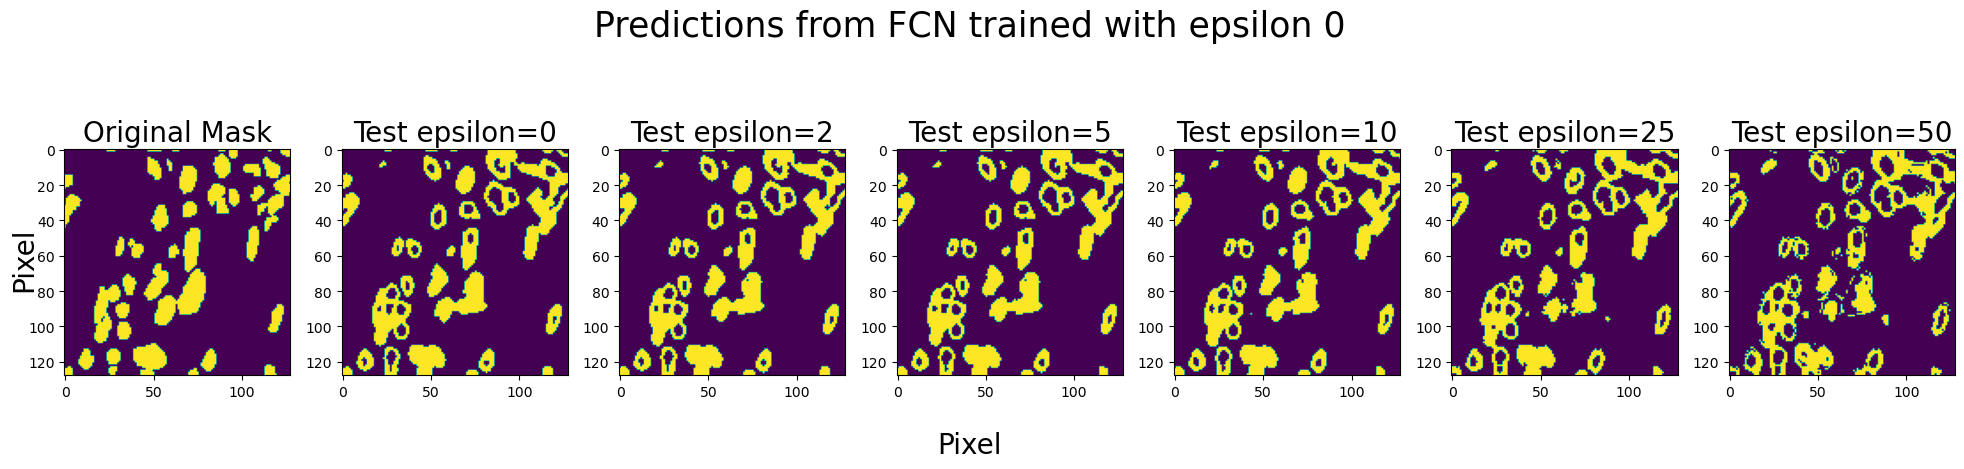

In [224]:
# # FCN trained on no epsilon
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(20, 10))

ax1.set_title('Original Mask', fontsize=20)
ax1.imshow(np.squeeze(y_test[2]))

ax2.set_title('Test epsilon=0', fontsize=20)
ax2.imshow(np.squeeze(fcnep0_preds_y[0][2]))


ax3.set_title('Test epsilon=2', fontsize=20)
ax3.imshow(np.squeeze(fcnep0_preds_y[1][2]))

ax4.set_title('Test epsilon=5', fontsize=20)
ax4.imshow(np.squeeze(fcnep0_preds_y[2][2]))

ax5.set_title('Test epsilon=10', fontsize=20)
ax5.imshow(np.squeeze(fcnep0_preds_y[3][2]))

ax6.set_title('Test epsilon=25', fontsize=20)
ax6.imshow(np.squeeze(fcnep0_preds_y[4][2]))

ax7.set_title('Test epsilon=50', fontsize=20)
ax7.imshow(np.squeeze(fcnep0_preds_y[5][2]))


fig.suptitle('Predictions from FCN trained with epsilon 0', y=.75, fontsize=25)
fig.supxlabel('Pixel', y=.3, fontsize=20)
fig.supylabel('Pixel', fontsize=20)

fig.tight_layout()

plt.savefig('Preds_FCNep0_im2.png', bbox_inches='tight')



# FCN trained on no epsilon ---> Picking a diff plot
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(20, 10))

ax1.set_title('Original Mask', fontsize=20)
ax1.imshow(np.squeeze(y_test[25]))

ax2.set_title('Test epsilon=0', fontsize=20)
ax2.imshow(np.squeeze(fcnep0_preds_y[0][25]))

ax3.set_title('Test epsilon=2', fontsize=20)
ax3.imshow(np.squeeze(fcnep0_preds_y[1][25]))

ax4.set_title('Test epsilon=5', fontsize=20)
ax4.imshow(np.squeeze(fcnep0_preds_y[2][25]))

ax5.set_title('Test epsilon=10', fontsize=20)
ax5.imshow(np.squeeze(fcnep0_preds_y[3][25]))

ax6.set_title('Test epsilon=25', fontsize=20)
ax6.imshow(np.squeeze(fcnep0_preds_y[4][25]))

ax7.set_title('Test epsilon=50', fontsize=20)
ax7.imshow(np.squeeze(fcnep0_preds_y[5][25]))


fig.suptitle('Predictions from FCN trained with epsilon 0', y=.75, fontsize=25)
fig.supxlabel('Pixel', y=.3, fontsize=20)
fig.supylabel('Pixel', fontsize=20)

fig.tight_layout()

plt.savefig('Preds_FCNep0_im25.png', bbox_inches='tight')

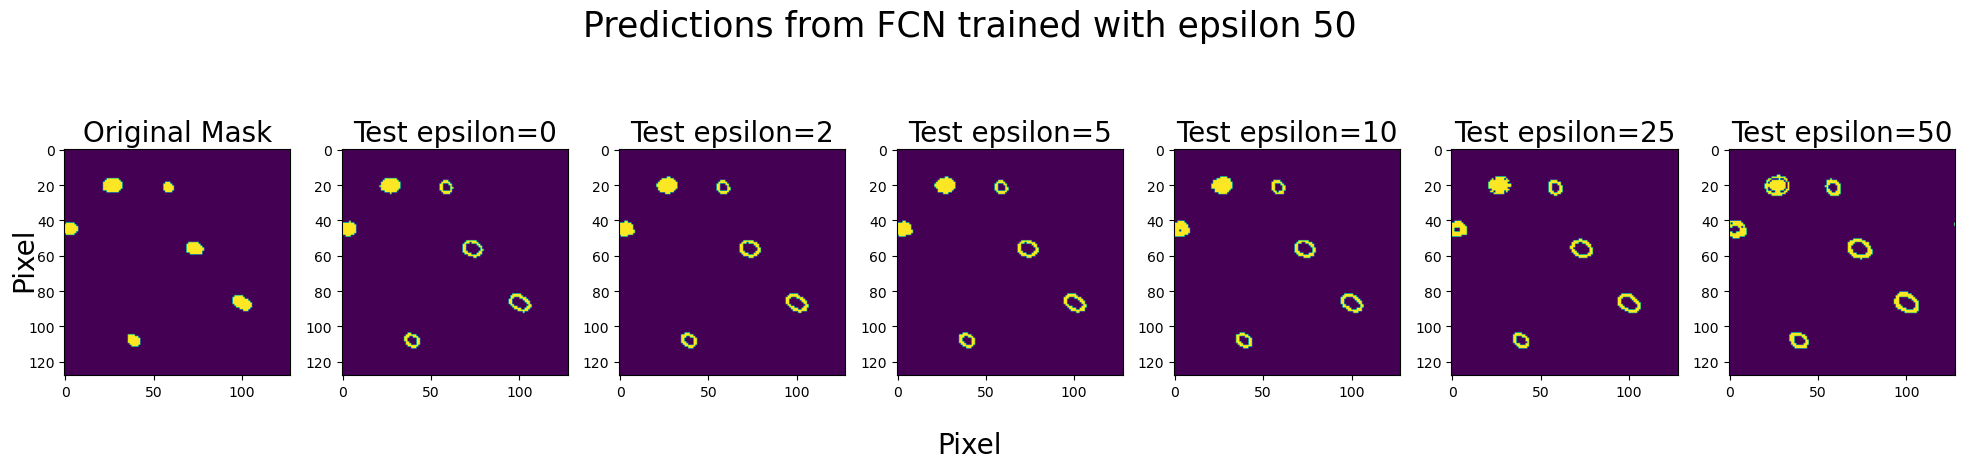

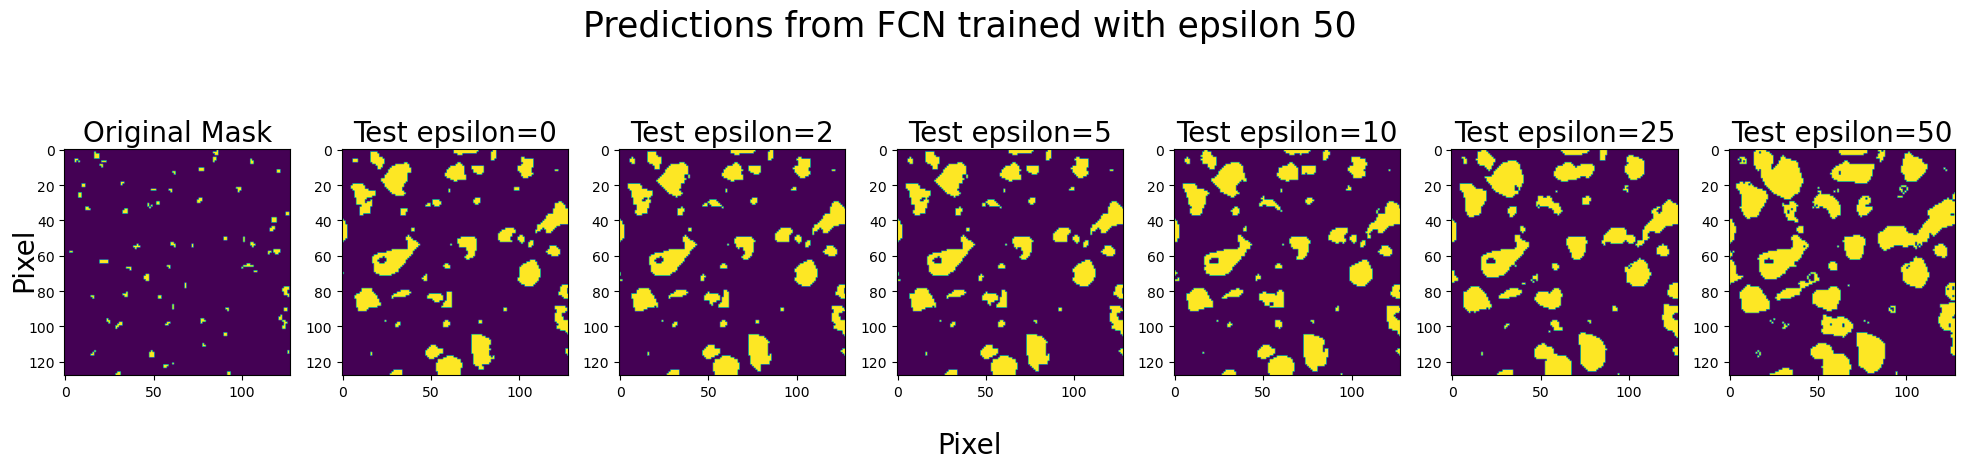

In [225]:
# technically the most robust model 
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(20, 10))

ax1.set_title('Original Mask', fontsize=20)
ax1.imshow(np.squeeze(y_test[2]))

ax2.set_title('Test epsilon=0', fontsize=20)
ax2.imshow(np.squeeze(fcnep50_preds_y[0][2]))


ax3.set_title('Test epsilon=2', fontsize=20)
ax3.imshow(np.squeeze(fcnep50_preds_y[1][2]))

ax4.set_title('Test epsilon=5', fontsize=20)
ax4.imshow(np.squeeze(fcnep50_preds_y[2][2]))

ax5.set_title('Test epsilon=10', fontsize=20)
ax5.imshow(np.squeeze(fcnep50_preds_y[3][2]))

ax6.set_title('Test epsilon=25', fontsize=20)
ax6.imshow(np.squeeze(fcnep50_preds_y[4][2]))

ax7.set_title('Test epsilon=50', fontsize=20)
ax7.imshow(np.squeeze(fcnep50_preds_y[5][2]))


fig.suptitle('Predictions from FCN trained with epsilon 50', y=.75, fontsize=25)
fig.supxlabel('Pixel', y=.3, fontsize=20)
fig.supylabel('Pixel', fontsize=20)

fig.tight_layout()

plt.savefig('Preds_FCNep50_im2.png', bbox_inches='tight')

# technically the most robust model 
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(20, 10))

ax1.set_title('Original Mask', fontsize=20)
ax1.imshow(np.squeeze(y_test[43]))

ax2.set_title('Test epsilon=0', fontsize=20)
ax2.imshow(np.squeeze(fcnep50_preds_y[0][43]))


ax3.set_title('Test epsilon=2', fontsize=20)
ax3.imshow(np.squeeze(fcnep50_preds_y[1][43]))

ax4.set_title('Test epsilon=5', fontsize=20)
ax4.imshow(np.squeeze(fcnep50_preds_y[2][43]))

ax5.set_title('Test epsilon=10', fontsize=20)
ax5.imshow(np.squeeze(fcnep50_preds_y[3][43]))

ax6.set_title('Test epsilon=25', fontsize=20)
ax6.imshow(np.squeeze(fcnep50_preds_y[4][43]))

ax7.set_title('Test epsilon=50', fontsize=20)
ax7.imshow(np.squeeze(fcnep50_preds_y[5][43]))


fig.suptitle('Predictions from FCN trained with epsilon 50', y=.75, fontsize=25)
fig.supxlabel('Pixel', y=.3, fontsize=20)
fig.supylabel('Pixel', fontsize=20)

fig.tight_layout()

plt.savefig('Preds_FCNep50_im43.png', bbox_inches='tight')

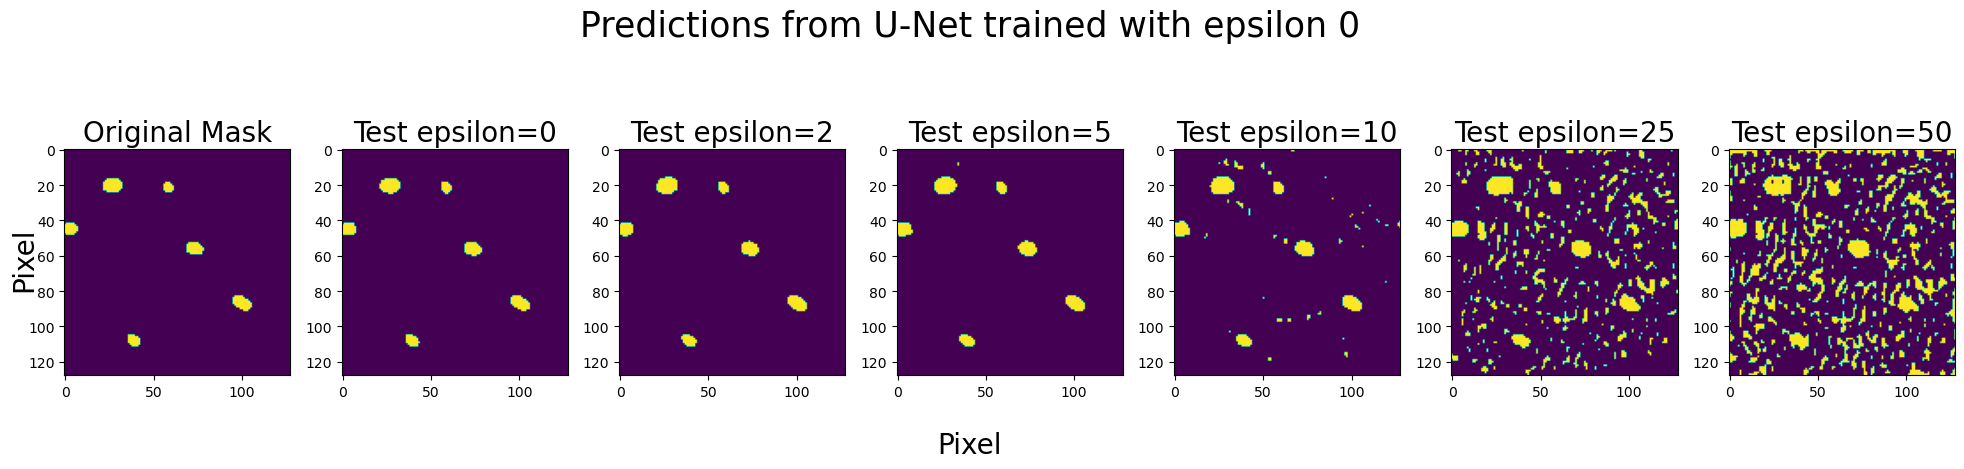

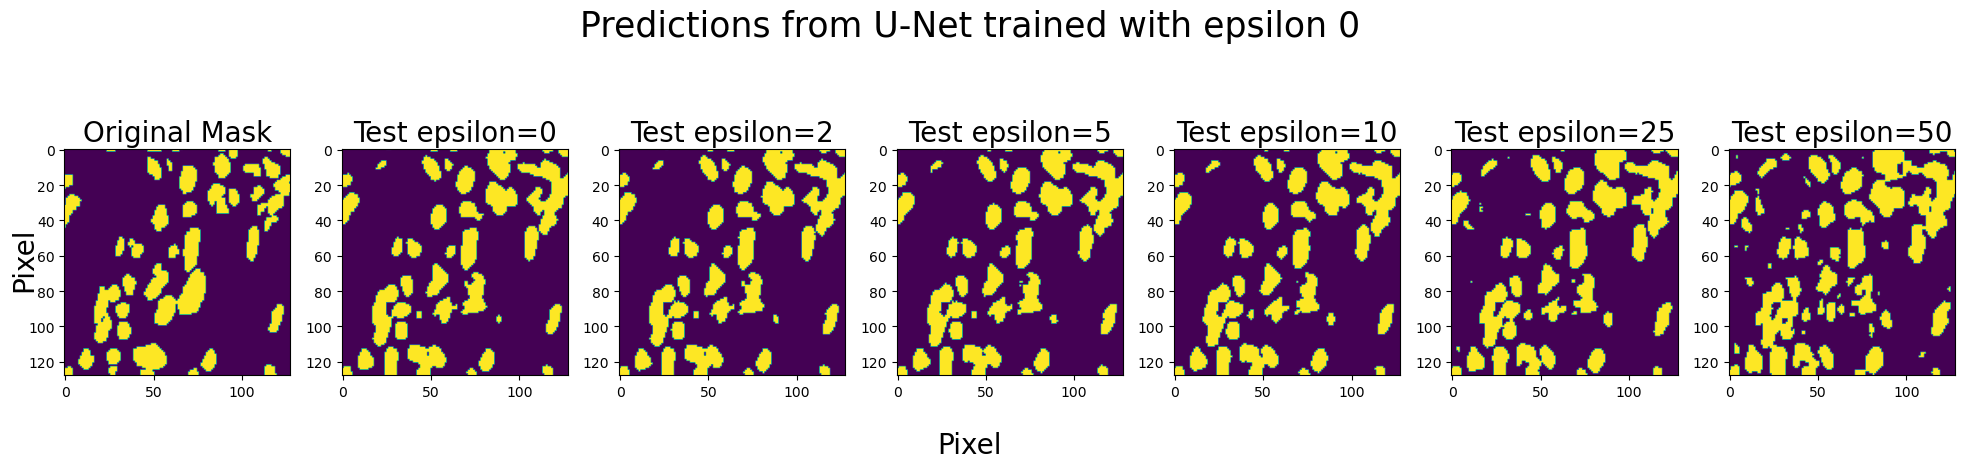

In [222]:
# technically the least robust model 
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(20, 10))

ax1.set_title('Original Mask', fontsize=20)
ax1.imshow(np.squeeze(y_test[2]))

ax2.set_title('Test epsilon=0', fontsize=20)
ax2.imshow(np.squeeze(unetep0_preds_y[0][2]))


ax3.set_title('Test epsilon=2', fontsize=20)
ax3.imshow(np.squeeze(unetep0_preds_y[1][2]))

ax4.set_title('Test epsilon=5', fontsize=20)
ax4.imshow(np.squeeze(unetep0_preds_y[2][2]))

ax5.set_title('Test epsilon=10', fontsize=20)
ax5.imshow(np.squeeze(unetep0_preds_y[3][2]))

ax6.set_title('Test epsilon=25', fontsize=20)
ax6.imshow(np.squeeze(unetep0_preds_y[4][2]))

ax7.set_title('Test epsilon=50', fontsize=20)
ax7.imshow(np.squeeze(unetep0_preds_y[5][2]))


fig.suptitle('Predictions from U-Net trained with epsilon 0', y=.75, fontsize=25)
fig.supxlabel('Pixel', y=.3, fontsize=20)
fig.supylabel('Pixel', fontsize=20)

fig.tight_layout()

plt.savefig('Preds_UNetep0_im2.png', bbox_inches='tight')

# technically the least robust model 
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(20, 10))

ax1.set_title('Original Mask', fontsize=20)
ax1.imshow(np.squeeze(y_test[25]))

ax2.set_title('Test epsilon=0', fontsize=20)
ax2.imshow(np.squeeze(unetep0_preds_y[0][25]))


ax3.set_title('Test epsilon=2', fontsize=20)
ax3.imshow(np.squeeze(unetep0_preds_y[1][25]))

ax4.set_title('Test epsilon=5', fontsize=20)
ax4.imshow(np.squeeze(unetep0_preds_y[2][25]))

ax5.set_title('Test epsilon=10', fontsize=20)
ax5.imshow(np.squeeze(unetep0_preds_y[3][25]))

ax6.set_title('Test epsilon=25', fontsize=20)
ax6.imshow(np.squeeze(unetep0_preds_y[4][25]))

ax7.set_title('Test epsilon=50', fontsize=20)
ax7.imshow(np.squeeze(unetep0_preds_y[5][25]))


fig.suptitle('Predictions from U-Net trained with epsilon 0', y=.75, fontsize=25)
fig.supxlabel('Pixel', y=.3, fontsize=20)
fig.supylabel('Pixel', fontsize=20)

fig.tight_layout()

plt.savefig('Preds_UNetep0_im25.png', bbox_inches='tight')

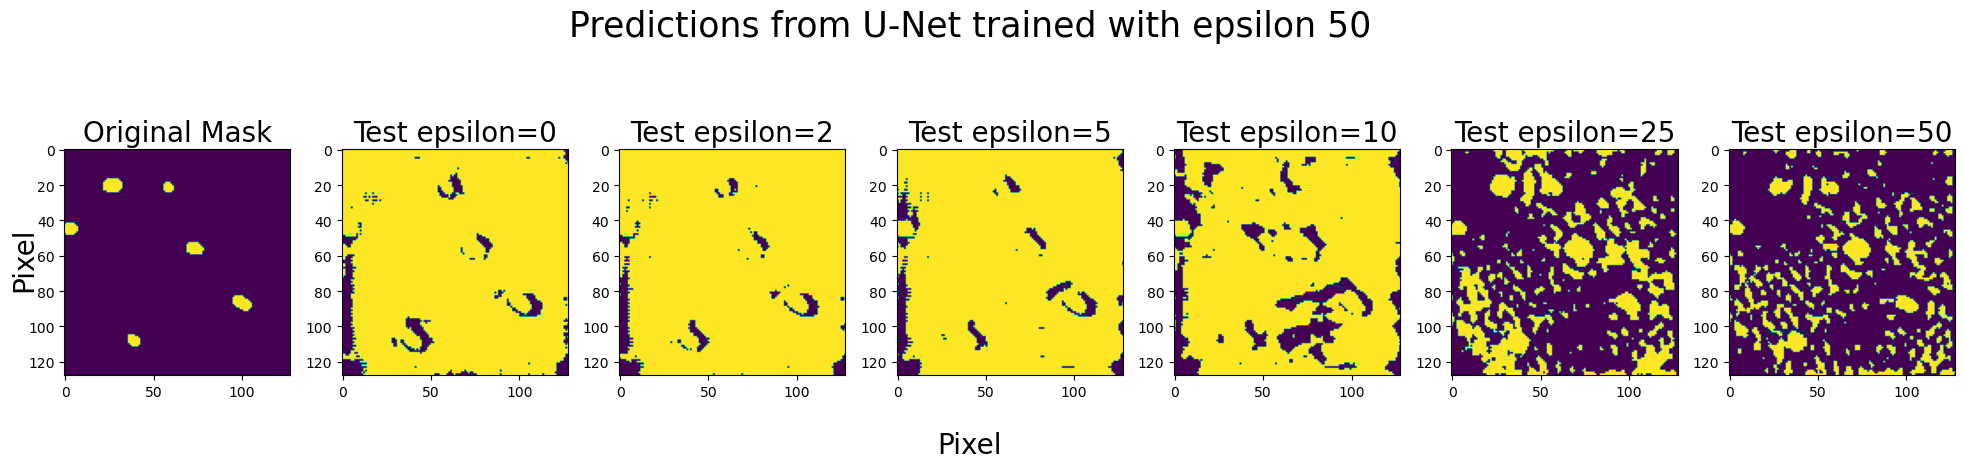

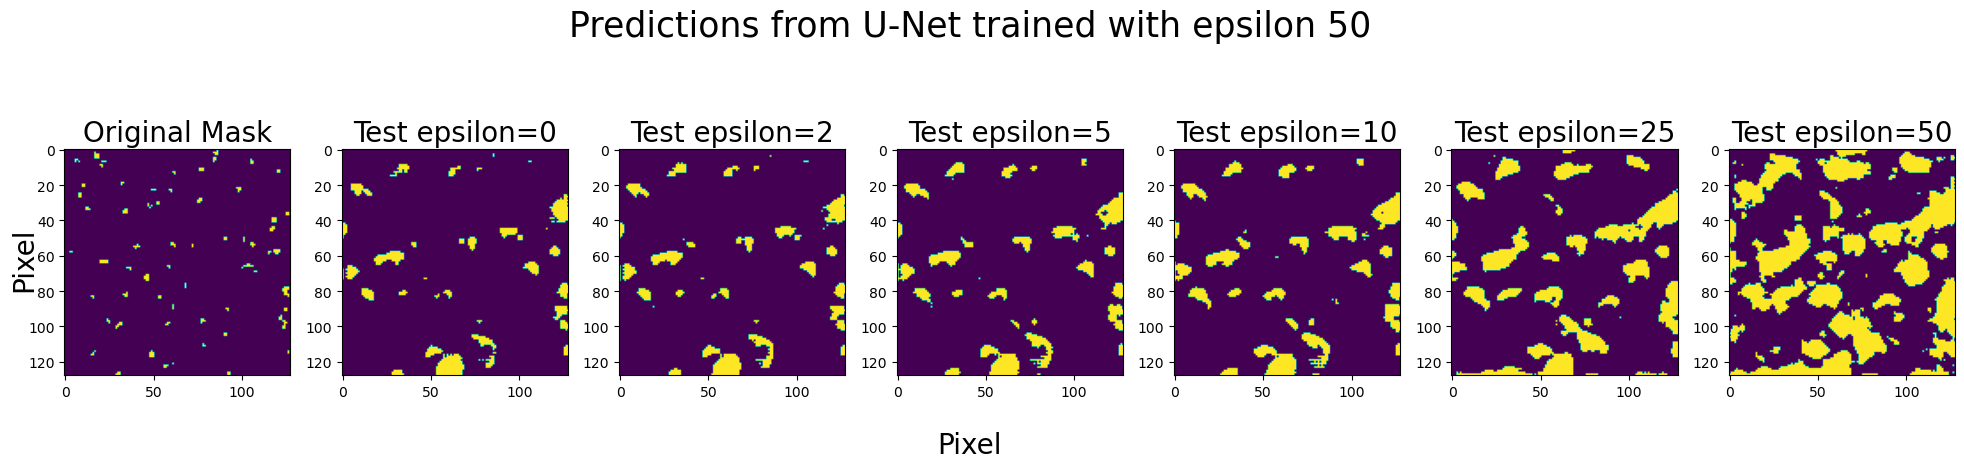

In [226]:
# technically the least robust model 
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(20, 10))

ax1.set_title('Original Mask', fontsize=20)
ax1.imshow(np.squeeze(y_test[2]))

ax2.set_title('Test epsilon=0', fontsize=20)
ax2.imshow(np.squeeze(unetep50_preds_y[0][2]))


ax3.set_title('Test epsilon=2', fontsize=20)
ax3.imshow(np.squeeze(unetep50_preds_y[1][2]))

ax4.set_title('Test epsilon=5', fontsize=20)
ax4.imshow(np.squeeze(unetep50_preds_y[2][2]))

ax5.set_title('Test epsilon=10', fontsize=20)
ax5.imshow(np.squeeze(unetep50_preds_y[3][2]))

ax6.set_title('Test epsilon=25', fontsize=20)
ax6.imshow(np.squeeze(unetep50_preds_y[4][2]))

ax7.set_title('Test epsilon=50', fontsize=20)
ax7.imshow(np.squeeze(unetep50_preds_y[5][2]))


fig.suptitle('Predictions from U-Net trained with epsilon 50', y=.75, fontsize=25)
fig.supxlabel('Pixel', y=.3, fontsize=20)
fig.supylabel('Pixel', fontsize=20)

fig.tight_layout()

plt.savefig('Preds_UNetep50_im2.png', bbox_inches='tight')

# technically the least robust model 
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(20, 10))

ax1.set_title('Original Mask', fontsize=20)
ax1.imshow(np.squeeze(y_test[43]))

ax2.set_title('Test epsilon=0', fontsize=20)
ax2.imshow(np.squeeze(unetep50_preds_y[0][43]))


ax3.set_title('Test epsilon=2', fontsize=20)
ax3.imshow(np.squeeze(unetep50_preds_y[1][43]))

ax4.set_title('Test epsilon=5', fontsize=20)
ax4.imshow(np.squeeze(unetep50_preds_y[2][43]))

ax5.set_title('Test epsilon=10', fontsize=20)
ax5.imshow(np.squeeze(unetep50_preds_y[3][43]))

ax6.set_title('Test epsilon=25', fontsize=20)
ax6.imshow(np.squeeze(unetep50_preds_y[4][43]))

ax7.set_title('Test epsilon=50', fontsize=20)
ax7.imshow(np.squeeze(unetep50_preds_y[5][43]))


fig.suptitle('Predictions from U-Net trained with epsilon 50', y=.75, fontsize=25)
fig.supxlabel('Pixel', y=.3, fontsize=20)
fig.supylabel('Pixel', fontsize=20)

fig.tight_layout()

plt.savefig('Preds_UNetep50_im43.png', bbox_inches='tight')

In [227]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as prf
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, roc_auc_score, RocCurveDisplay

In [134]:
# plotting all the confusion matrices
titles_list = ['With ep=0','With ep=2', 'With ep=5', 'With ep=10', 'With ep=25', 'With ep=50']

def confusion(pred):
    #looping through the predictions:
    for i in range(len(pred)):
        cm = confusion_matrix(np.squeeze(y_test).flatten(), np.squeeze(pred[i]).flatten(), normalize='all')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        disp.ax_.set_title(titles_list[i])




/Users/nadejdaboev/opt/anaconda3/envs/monaiproject_repo/lib/python3.9/site-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


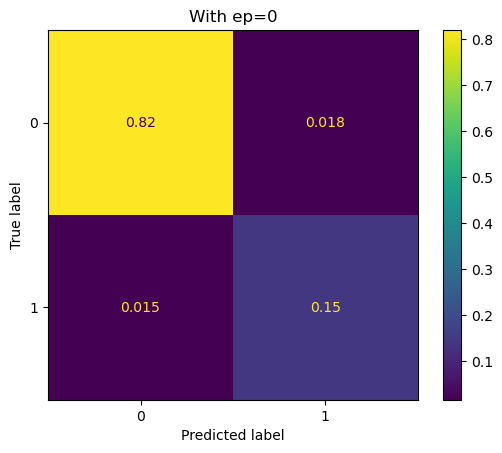

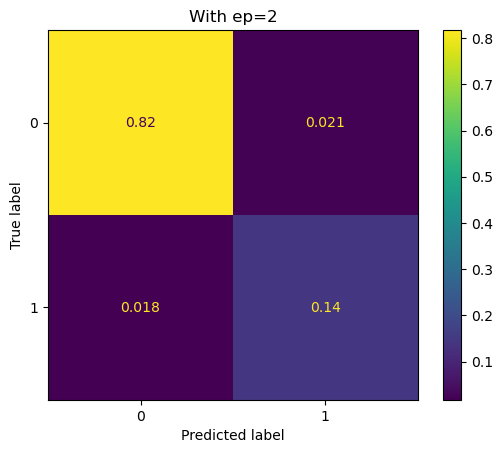

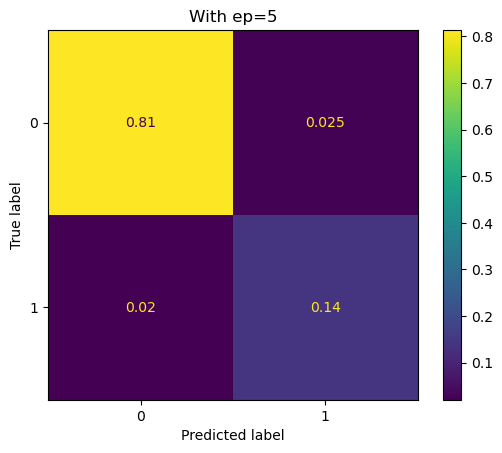

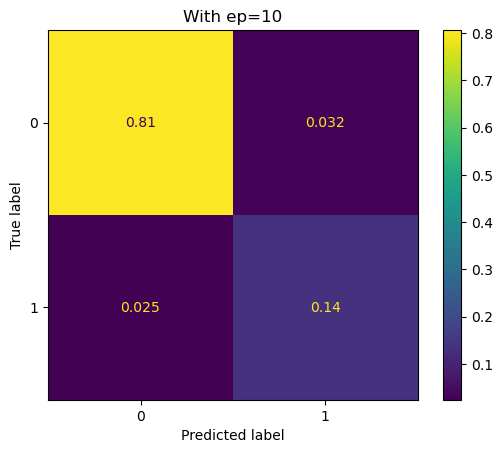

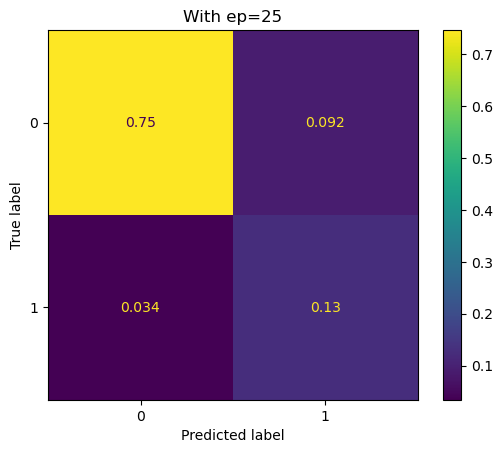

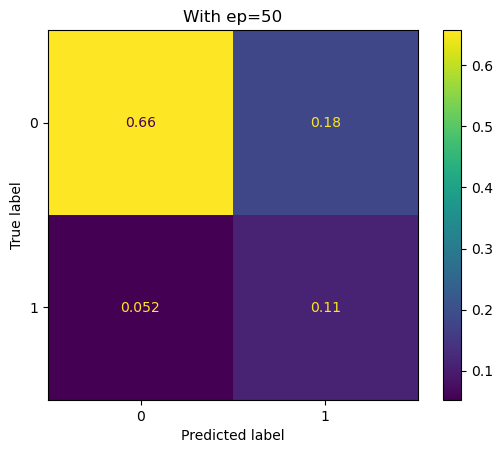

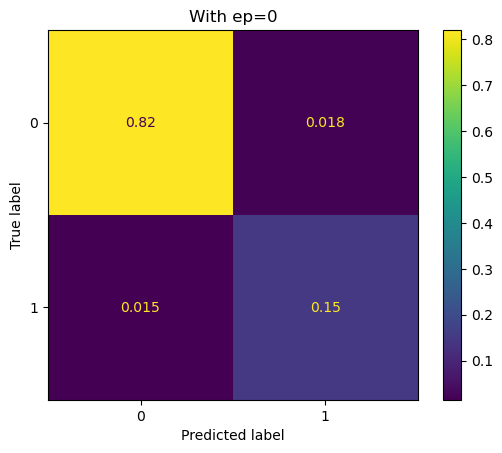

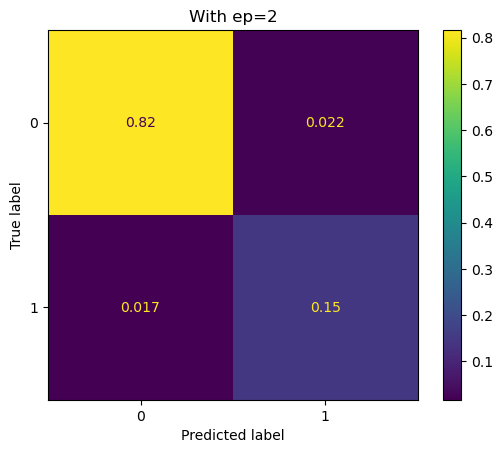

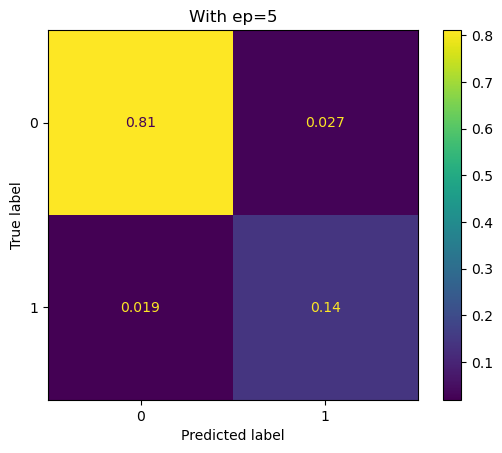

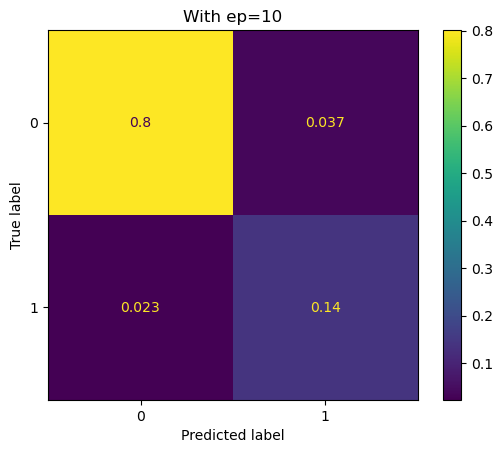

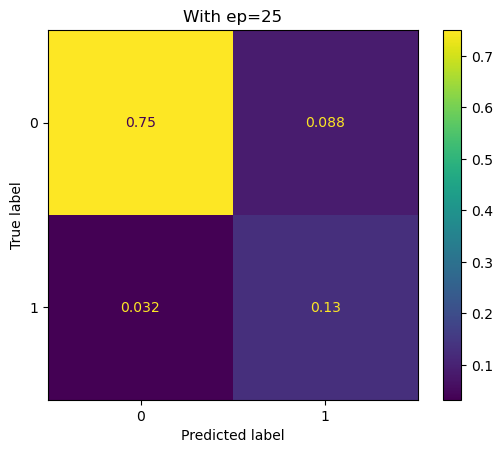

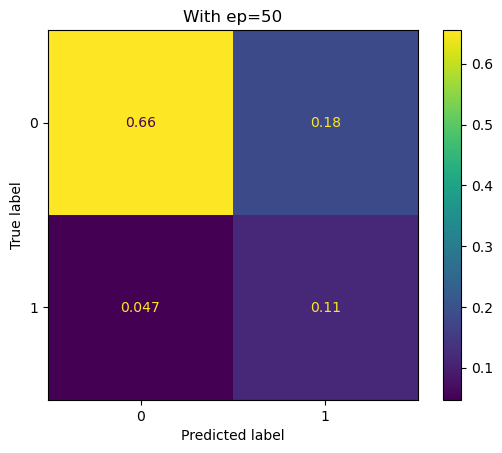

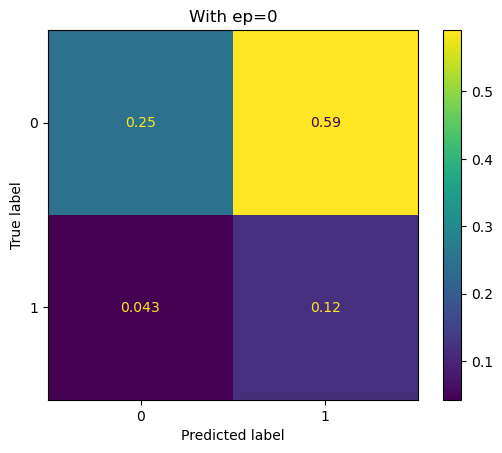

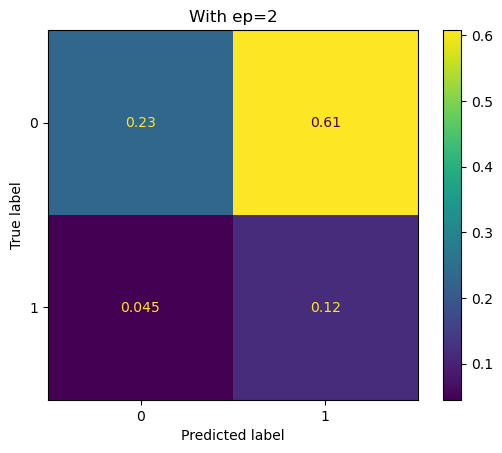

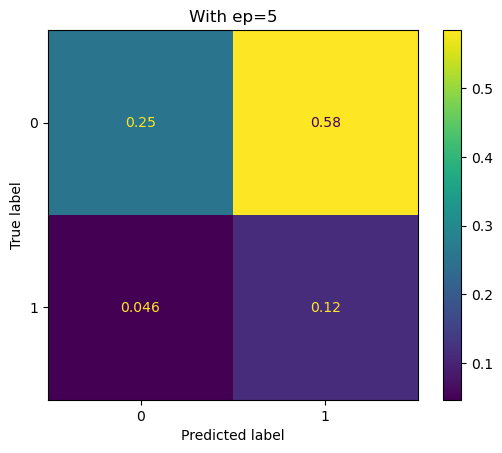

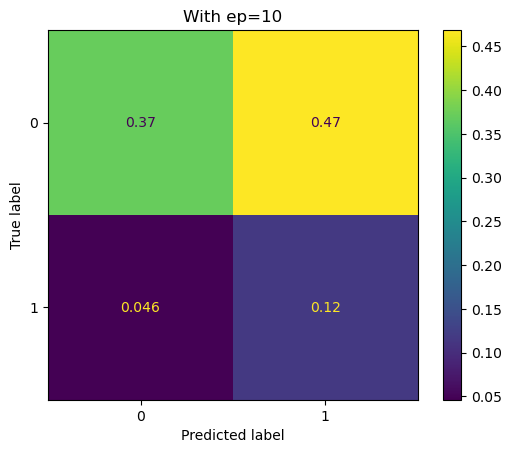

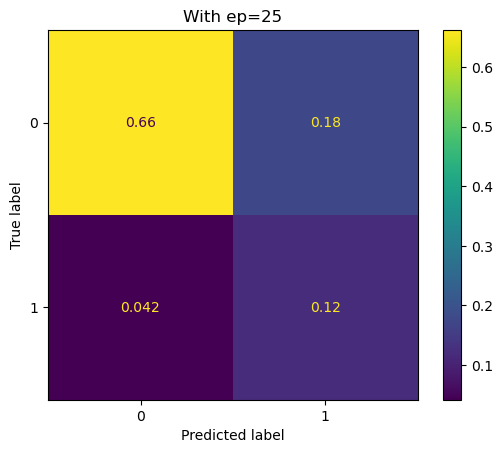

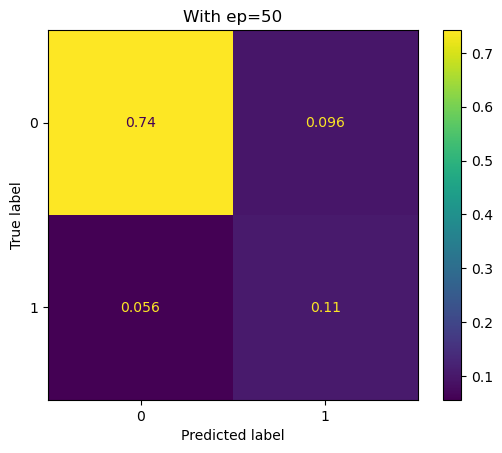

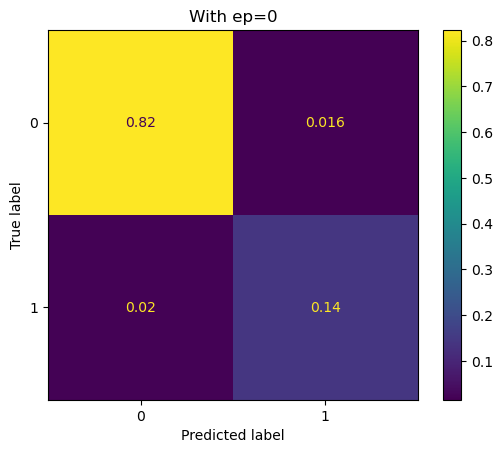

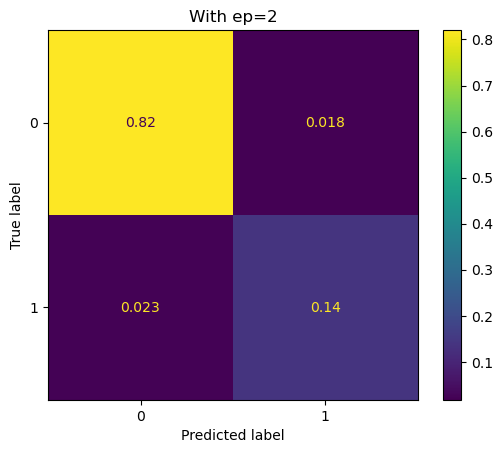

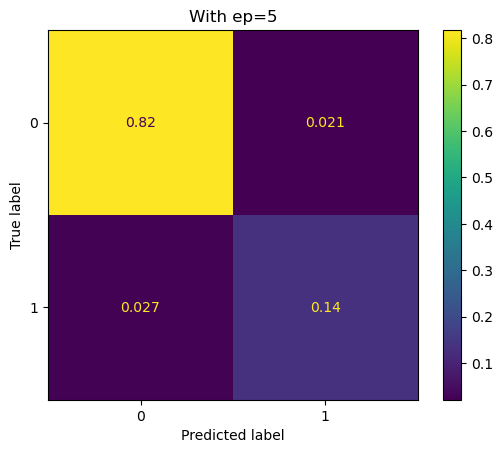

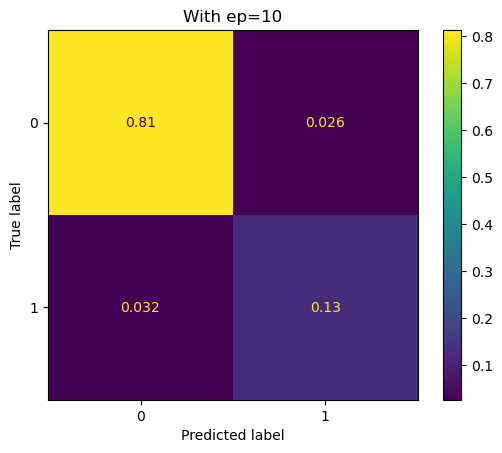

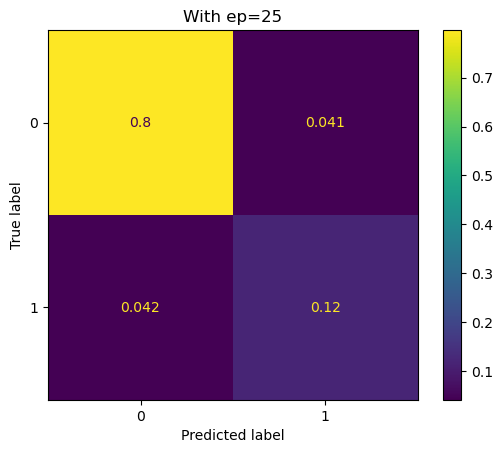

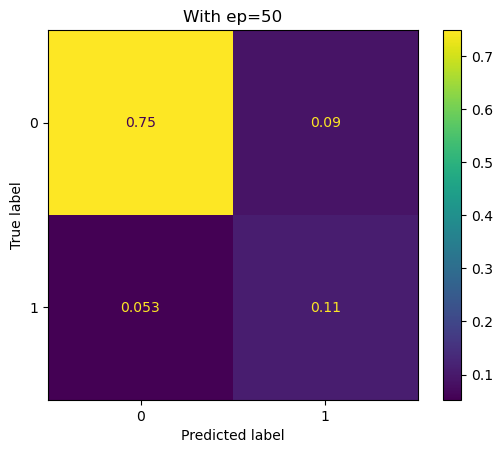

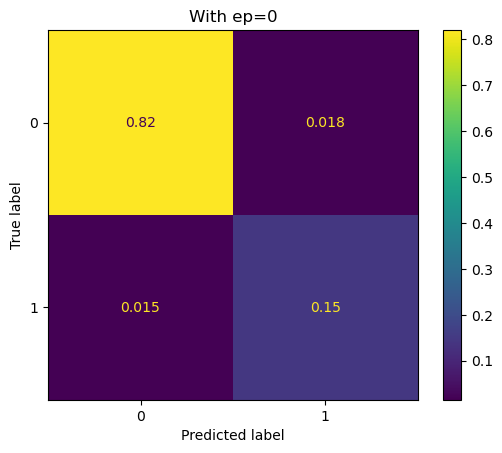

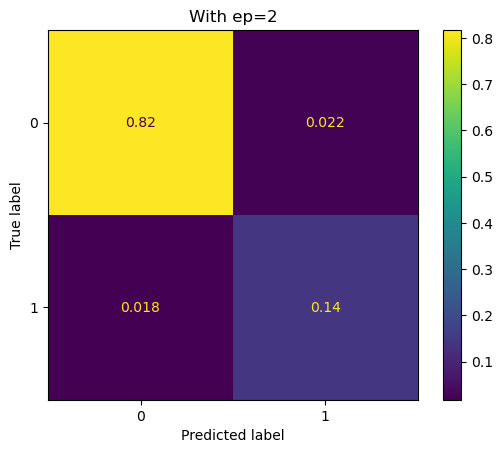

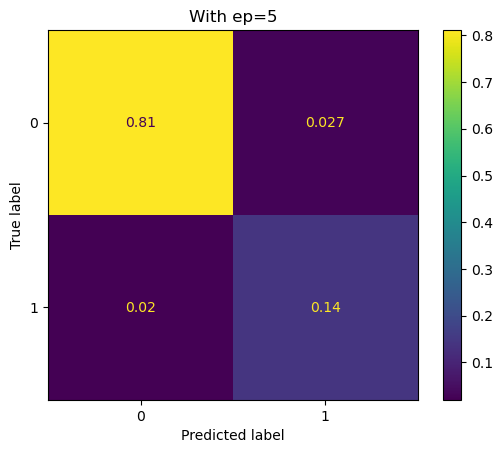

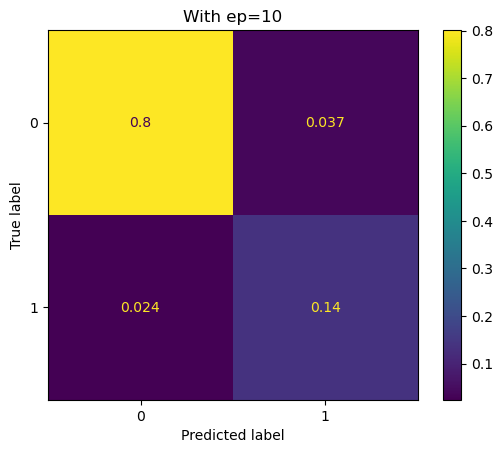

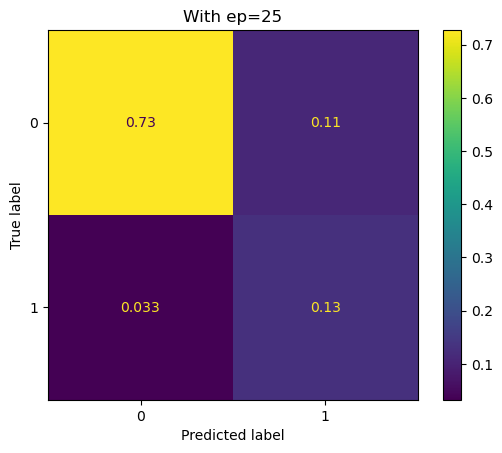

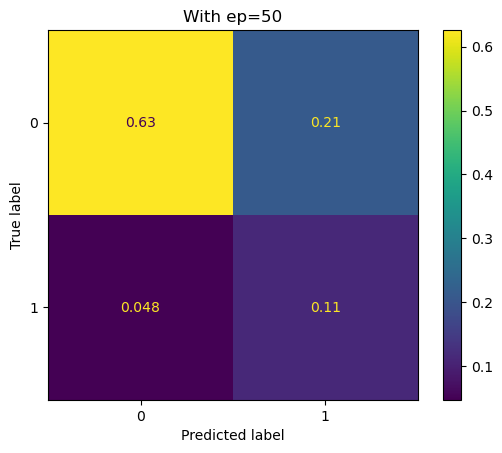

In [184]:
confusion(unetep0_preds_y)
confusion(unetep2_preds_y)
confusion(unetep50_preds_y)
confusion(unetepVAR_preds_y)
confusion(unetep2_05_preds_y)

/Users/nadejdaboev/opt/anaconda3/envs/monaiproject_repo/lib/python3.9/site-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


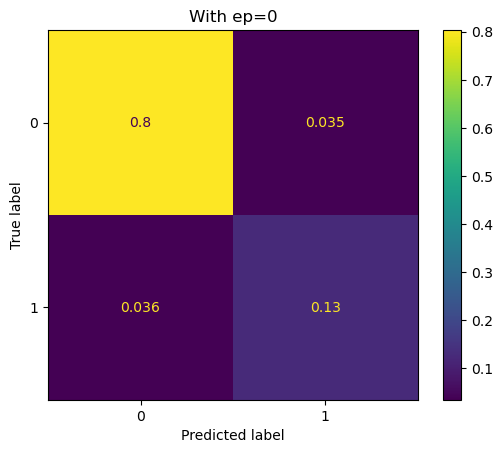

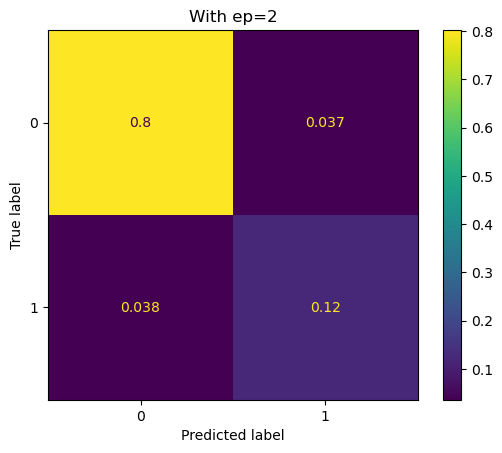

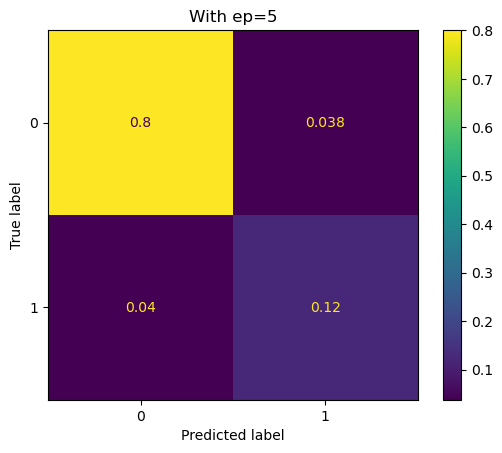

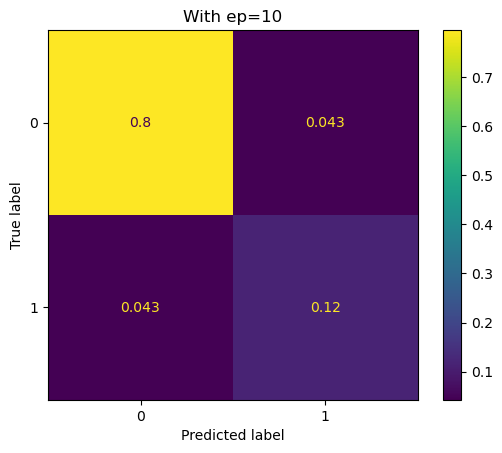

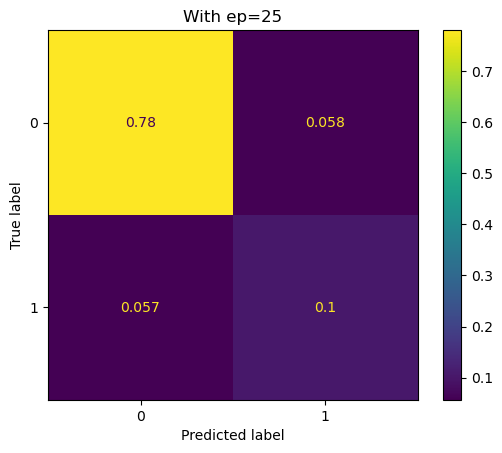

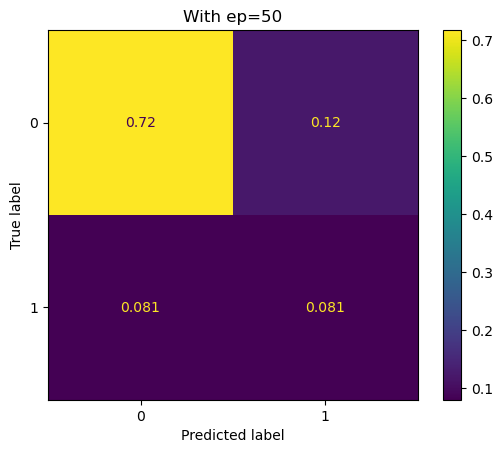

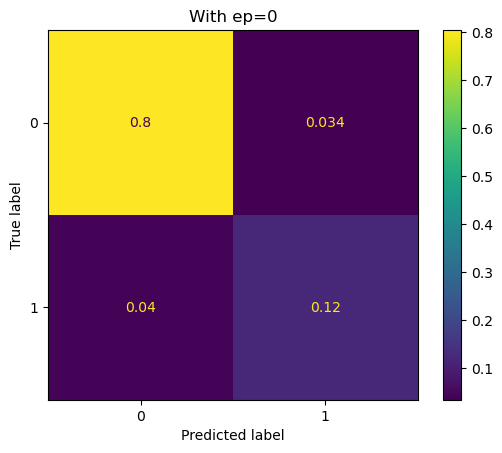

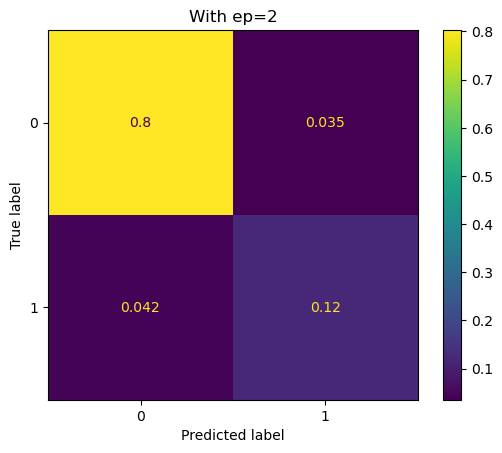

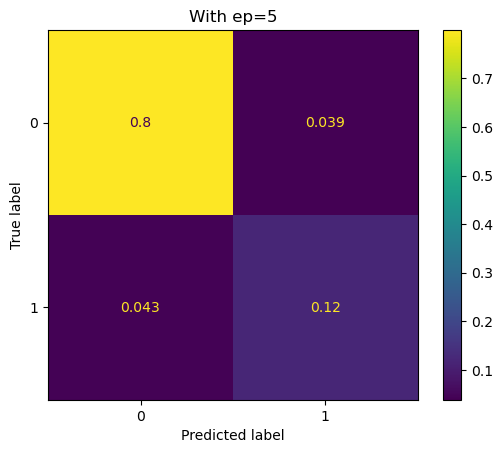

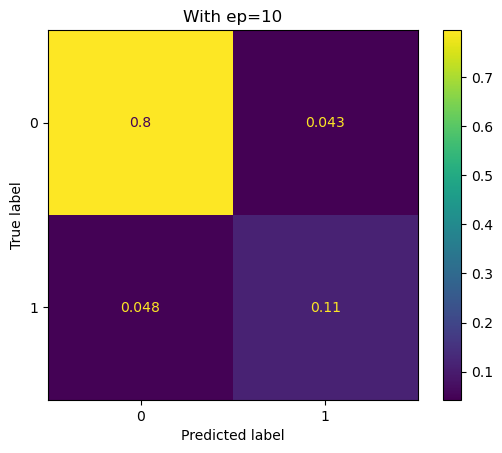

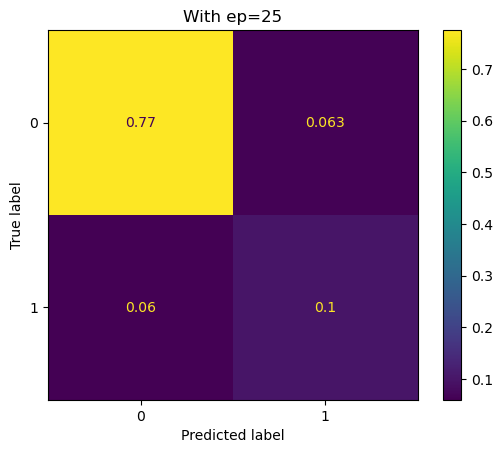

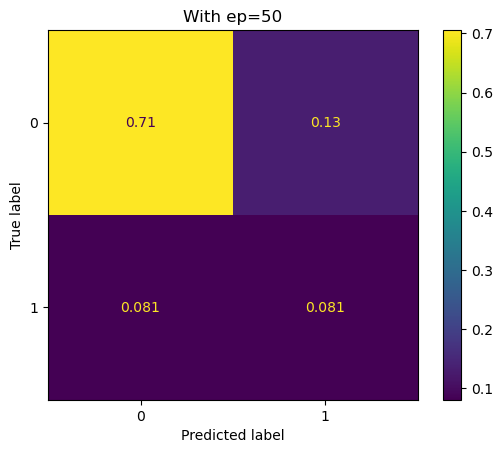

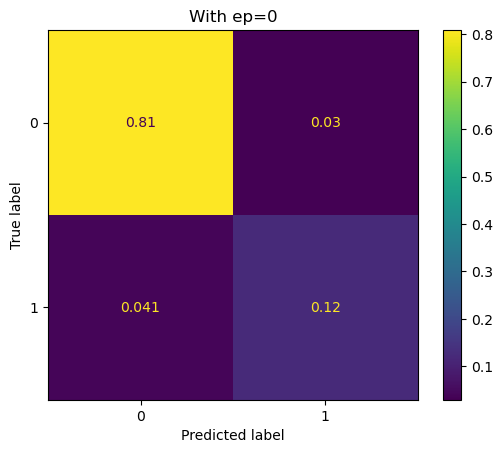

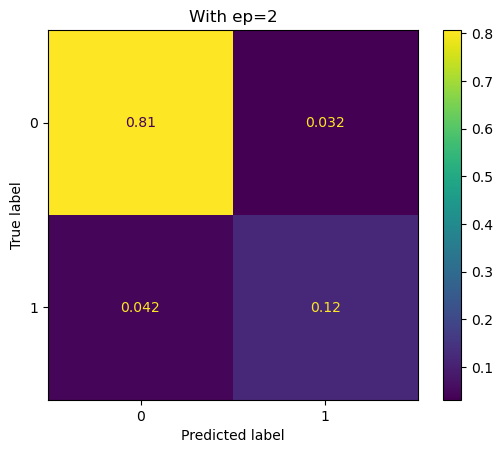

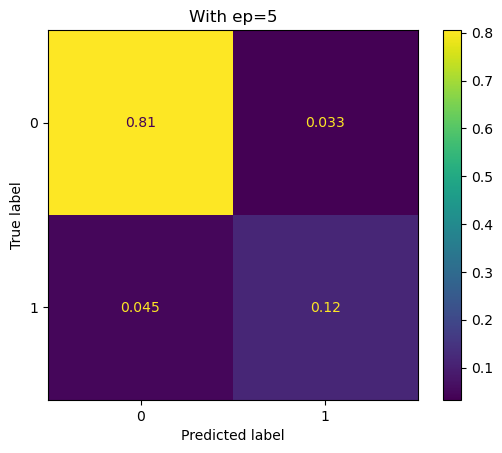

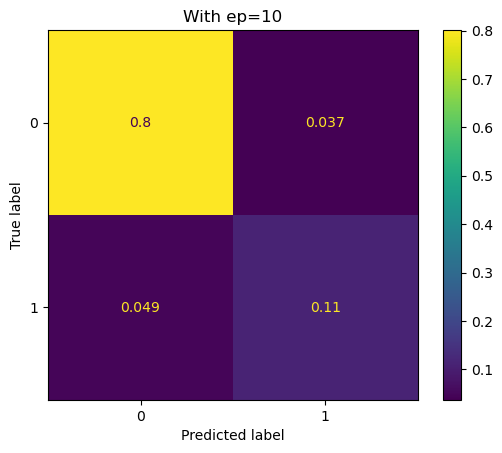

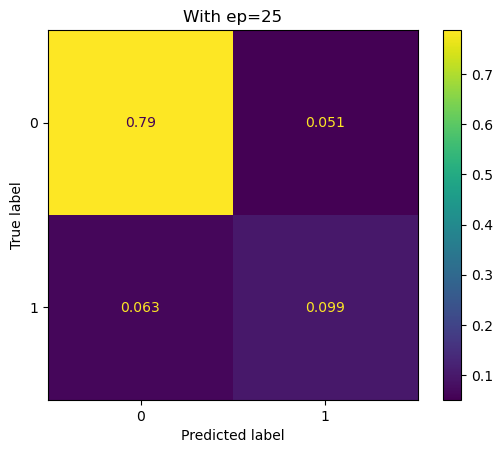

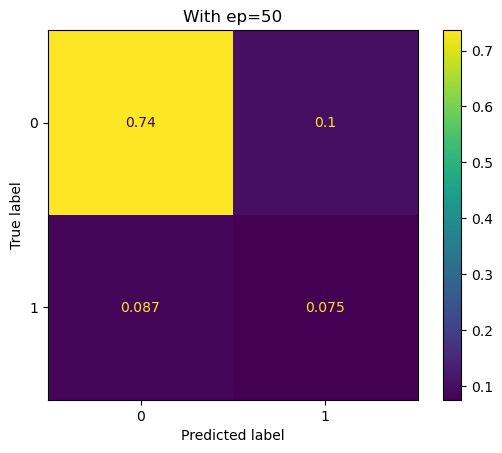

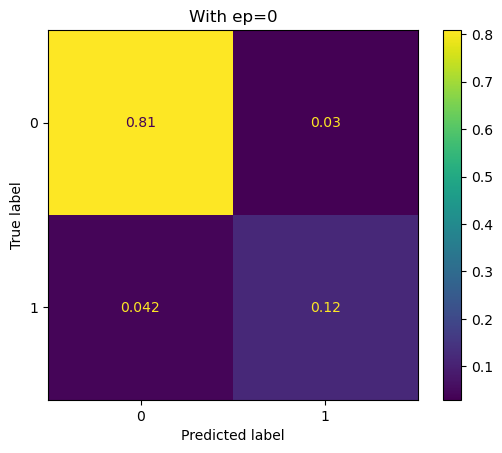

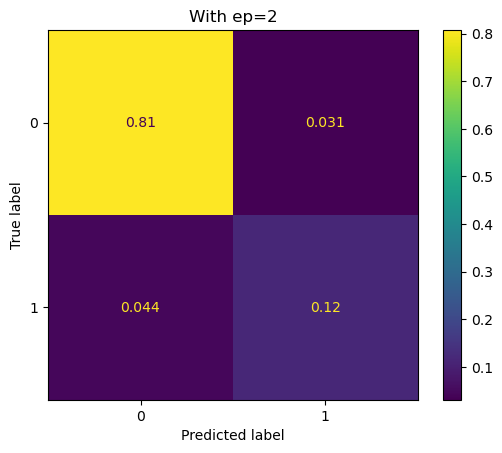

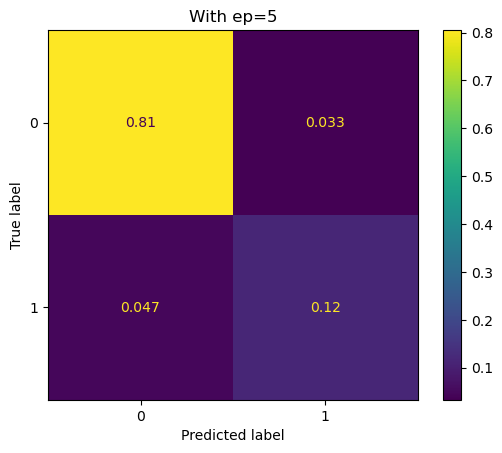

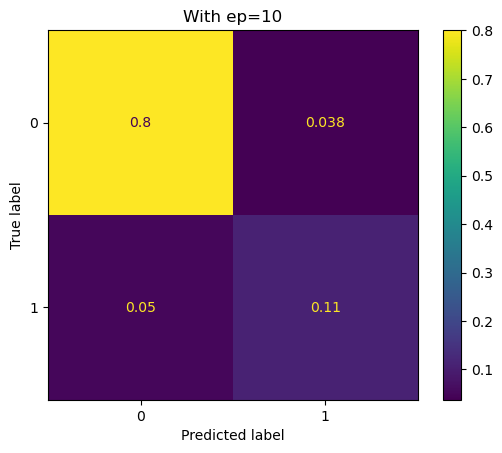

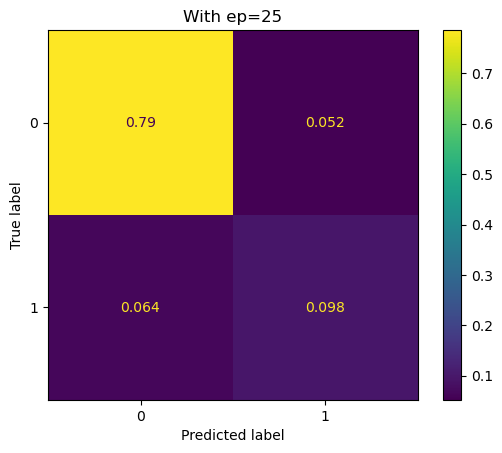

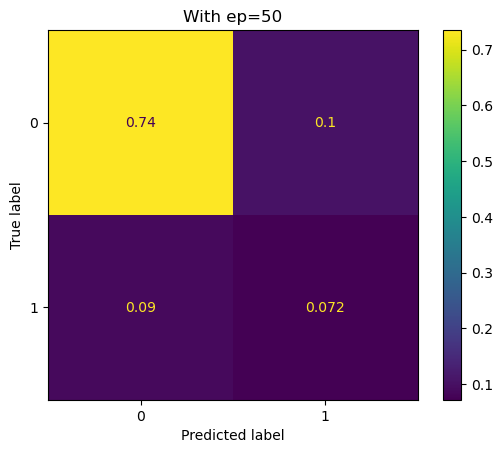

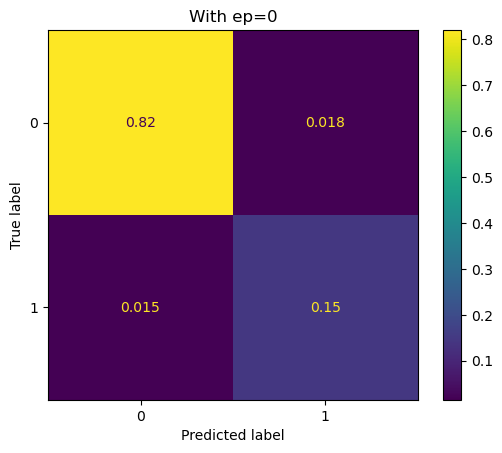

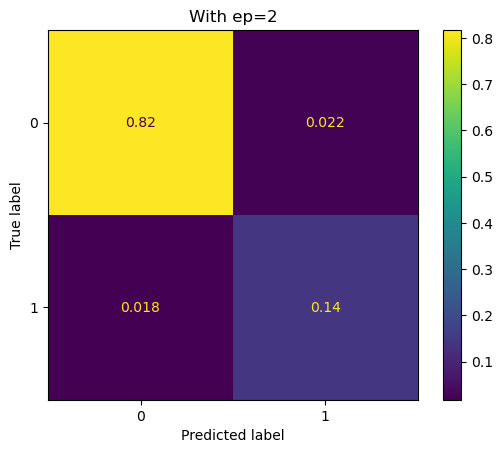

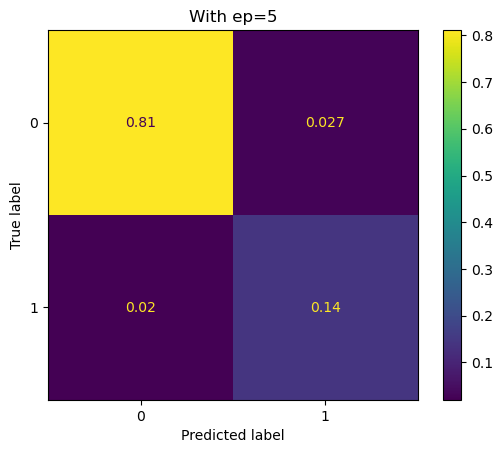

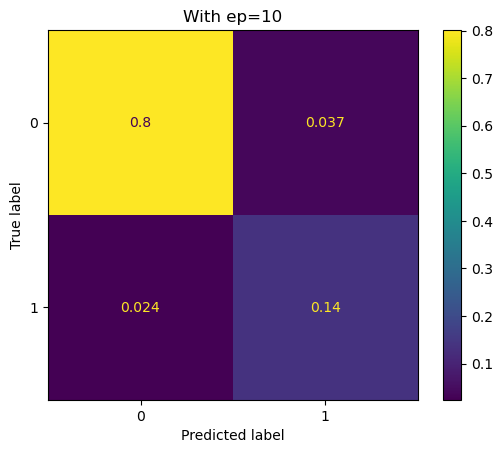

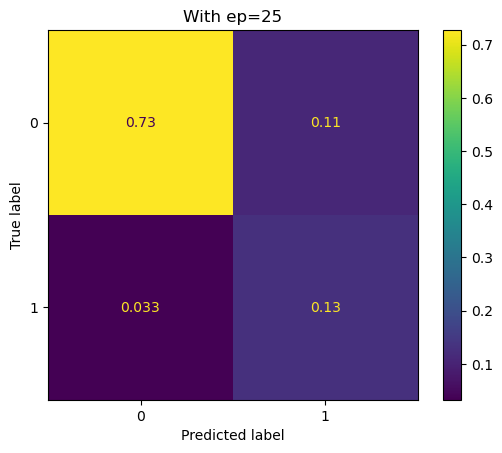

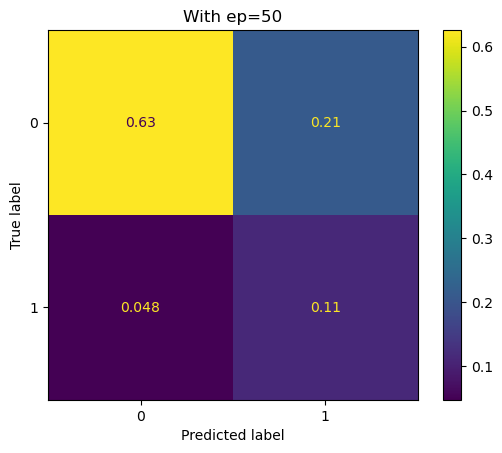

In [185]:
confusion(fcnep0_preds_y)
confusion(fcnep2_preds_y)
confusion(fcnep50_preds_y)
confusion(fcnepVAR_preds_y)
confusion(fcnep2_05_preds_y)

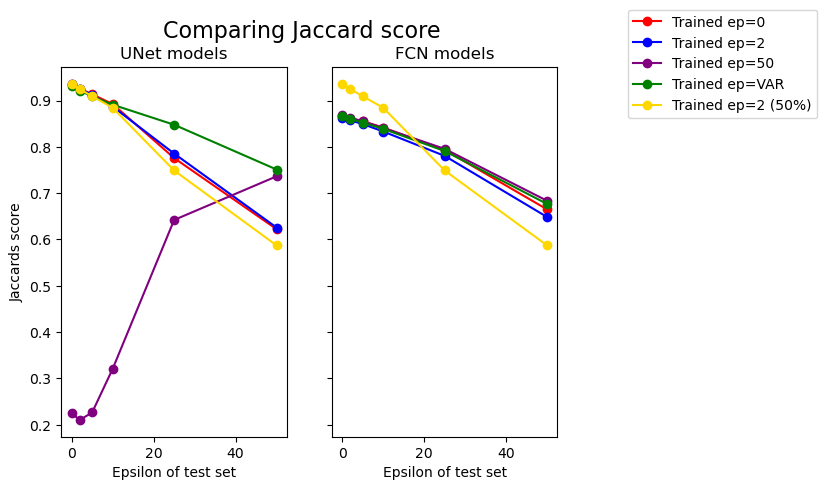

In [181]:
# Plotting Jaccards across the prediction results..
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

listing_preds = [unetep0_preds_y, unetep2_preds_y, unetep50_preds_y, unetepVAR_preds_y, unetep2_05_preds_y]
color = ['r', 'b', 'purple', 'g', 'gold']
labelling = ['Trained ep=0', 'Trained ep=2', 'Trained ep=50', 'Trained ep=VAR', 'Trained ep=2 (50%)']

eps = [0, 2, 5, 10, 25, 50 ]

for j in range(len(listing_preds)):
    predding = listing_preds[j]

    grabbing = []

    for i in range(len(fcnep0_preds_y)):
        grabbing.append(jaccard_score(np.squeeze(y_test).flatten(), np.squeeze(predding[i]).flatten(), average="micro"))

    ax1.plot(eps, grabbing, "-o", color = color[j], label=labelling[j])


listing_preds = [fcnep0_preds_y, fcnep2_preds_y, fcnep50_preds_y, fcnepVAR_preds_y, fcnep2_05_preds_y]

eps = [0, 2, 5, 10, 25, 50 ]

for j in range(len(listing_preds)):
    predding = listing_preds[j]

    grabbing = []

    for i in range(len(fcnep0_preds_y)):
        grabbing.append(jaccard_score(np.squeeze(y_test).flatten(), np.squeeze(predding[i]).flatten(), average="micro"))

    ax2.plot(eps, grabbing, "-o", color = color[j], label=labelling[j])


ax1.set_ylabel('Jaccards score')
ax1.set_xlabel('Epsilon of test set')
ax1.set_title('UNet models')

ax2.set_xlabel('Epsilon of test set')
ax2.set_title('FCN models')

f.legend(labels=labelling, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
f.suptitle('Comparing Jaccard score', fontsize=16)

f.savefig('Results_Jaccard_20233002.png', bbox_inches='tight')



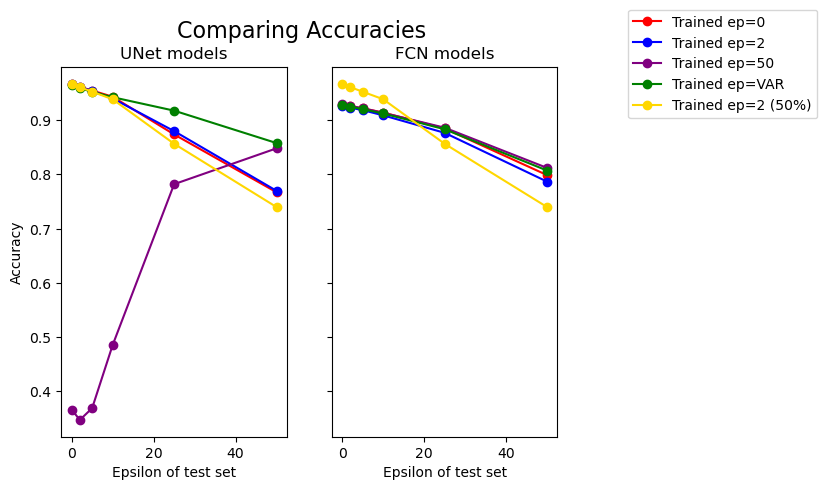

In [182]:
# Plotting Accuracy across the prediction results..
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

listing_preds = [unetep0_preds_y, unetep2_preds_y, unetep50_preds_y, unetepVAR_preds_y, unetep2_05_preds_y]
color = ['r', 'b', 'purple', 'g', 'gold']
labelling = ['Trained ep=0', 'Trained ep=2', 'Trained ep=50', 'Trained ep=VAR', 'Trained ep=2 (50%)']

eps = [0, 2, 5, 10, 25, 50 ]

for j in range(len(listing_preds)):
    predding = listing_preds[j]

    grabbing = []

    for i in range(len(fcnep0_preds_y)):
        grabbing.append(accuracy_score(np.squeeze(y_test).flatten(), np.squeeze(predding[i]).flatten()))

    ax1.plot(eps, grabbing, "-o", color = color[j], label=labelling[j])


listing_preds = [fcnep0_preds_y, fcnep2_preds_y, fcnep50_preds_y, fcnepVAR_preds_y, fcnep2_05_preds_y]

eps = [0, 2, 5, 10, 25, 50 ]

for j in range(len(listing_preds)):
    predding = listing_preds[j]

    grabbing = []

    for i in range(len(fcnep0_preds_y)):
        grabbing.append(accuracy_score(np.squeeze(y_test).flatten(), np.squeeze(predding[i]).flatten()))

    ax2.plot(eps, grabbing, "-o", color = color[j], label=labelling[j])


ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epsilon of test set')
ax1.set_title('UNet models')

ax2.set_xlabel('Epsilon of test set')
ax2.set_title('FCN models')

f.legend(labels=labelling, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
f.suptitle('Comparing Accuracies', fontsize=16)

f.savefig('Results_Accuracy_20233002.png', bbox_inches='tight')


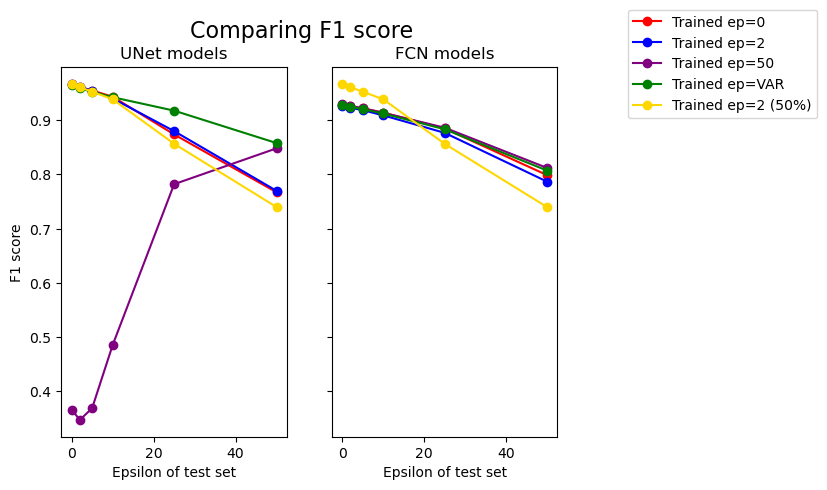

In [183]:
# Plotting F1 across the prediction results..
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

listing_preds = [unetep0_preds_y, unetep2_preds_y, unetep50_preds_y, unetepVAR_preds_y, unetep2_05_preds_y]
color = ['r', 'b', 'purple', 'g', 'gold']
labelling = ['Trained ep=0', 'Trained ep=2', 'Trained ep=50', 'Trained ep=VAR', 'Trained ep=2 (50%)']

eps = [0, 2, 5, 10, 25, 50 ]

for j in range(len(listing_preds)):
    predding = listing_preds[j]

    grabbing = []

    for i in range(len(fcnep0_preds_y)):
        grabbing.append(f1_score(np.squeeze(y_test).flatten(), np.squeeze(predding[i]).flatten(), average="micro"))

    ax1.plot(eps, grabbing, "-o", color = color[j], label=labelling[j])


listing_preds = [fcnep0_preds_y, fcnep2_preds_y, fcnep50_preds_y, fcnepVAR_preds_y, fcnep2_05_preds_y]

eps = [0, 2, 5, 10, 25, 50 ]

for j in range(len(listing_preds)):
    predding = listing_preds[j]

    grabbing = []

    for i in range(len(fcnep0_preds_y)):
        grabbing.append(f1_score(np.squeeze(y_test).flatten(), np.squeeze(predding[i]).flatten(), average="micro"))

    ax2.plot(eps, grabbing, "-o", color = color[j], label=labelling[j])


ax1.set_ylabel('F1 score')
ax1.set_xlabel('Epsilon of test set')
ax1.set_title('UNet models')

ax2.set_xlabel('Epsilon of test set')
ax2.set_title('FCN models')

f.legend(labels=labelling, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
f.suptitle('Comparing F1 score', fontsize=16)

f.savefig('Results_F1_20233002.png', bbox_inches='tight')



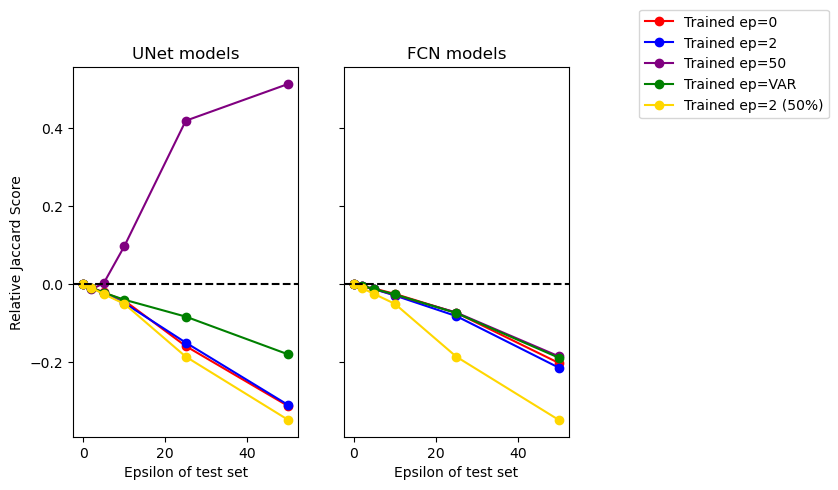

In [236]:
# Attempting to describe robustness!!
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)


color = ['r', 'b', 'purple', 'g', 'gold']
labelling = ['Trained ep=0', 'Trained ep=2', 'Trained ep=50', 'Trained ep=VAR', 'Trained ep=2 (50%)']
eps = [0, 2, 5, 10, 25, 50 ]

listing_preds = [unetep0_preds_y, unetep2_preds_y, unetep50_preds_y, unetepVAR_preds_y, unetep2_05_preds_y]

for j in range(len(listing_preds)):
    predding = listing_preds[j]

    grabbing = []
    diff = []

    for i in range(len(fcnep0_preds_y)):
        grabbing.append(jaccard_score(np.squeeze(y_test).flatten(), np.squeeze(predding[i]).flatten(), average="micro"))
    for i in grabbing:
        diff.append(i - grabbing[0])
        
    ax1.plot(eps, diff, "-o", color = color[j], label=labelling[j])

listing_preds = [fcnep0_preds_y, fcnep2_preds_y, fcnep50_preds_y, fcnepVAR_preds_y, fcnep2_05_preds_y]
for j in range(len(listing_preds)):
    predding = listing_preds[j]

    grabbing = []
    diff = []

    for i in range(len(fcnep0_preds_y)):
        grabbing.append(jaccard_score(np.squeeze(y_test).flatten(), np.squeeze(predding[i]).flatten(), average="micro"))
    for i in grabbing:
        diff.append(i - grabbing[0])
        
    ax2.plot(eps, diff, "-o", color = color[j], label=labelling[j])

    

ax1.set_ylabel('Relative Jaccard Score')
ax1.set_xlabel('Epsilon of test set')
ax1.set_title('UNet models')
ax1.axhline(y = 0, color = 'k', linestyle = '--')

ax2.set_xlabel('Epsilon of test set')
ax2.set_title('FCN models')
ax2.axhline(y = 0, color = 'k', linestyle = '--')

f.legend(labels=labelling, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
f.savefig('Results_relative_20233002.png', bbox_inches='tight')



In [244]:
# Attempting to describe robustness!! --> let's get the average across the epsilon values

arch_list= []
model_list = []
epsilon_list = []
diff_list = []

listing_preds = [unetep0_preds_y, unetep2_preds_y, unetep50_preds_y, unetepVAR_preds_y, unetep2_05_preds_y]
labelling = ['Trained ep=0', 'Trained ep=2', 'Trained ep=50', 'Trained ep=VAR', 'Trained ep=2 (50%)']

for j in range(len(listing_preds)):
    predding = listing_preds[j]
    grabbing = []
    diff = []
    
    arch_list.append(['U-Net', 'U-Net', 'U-Net', 'U-Net', 'U-Net', 'U-Net'])
    model_list.append([labelling[j], labelling[j], labelling[j],labelling[j],labelling[j],labelling[j],])
    epsilon_list.append([0, 2, 5, 10, 25, 50 ])

    for i in range(len(fcnep0_preds_y)):
        grabbing.append(jaccard_score(np.squeeze(y_test).flatten(), np.squeeze(predding[i]).flatten(), average="micro"))
    for i in grabbing:
        diff.append(i - grabbing[0])
        
    diff_list.append(diff)
        
listing_preds = [fcnep0_preds_y, fcnep2_preds_y, fcnep50_preds_y, fcnepVAR_preds_y, fcnep2_05_preds_y]
for j in range(len(listing_preds)):
    predding = listing_preds[j]
    grabbing = []
    diff = []
    
    arch_list.append(['FCN','FCN','FCN','FCN','FCN','FCN' ])
    model_list.append([labelling[j], labelling[j], labelling[j],labelling[j],labelling[j],labelling[j],])
    epsilon_list.append([0, 2, 5, 10, 25, 50 ])

    for i in range(len(fcnep0_preds_y)):
        grabbing.append(jaccard_score(np.squeeze(y_test).flatten(), np.squeeze(predding[i]).flatten(), average="micro"))
    for i in grabbing:
        diff.append(i - grabbing[0])
        
    diff_list.append(diff)



In [246]:
arch_list = sum(arch_list, [])
model_list = sum(model_list, [])
epsilon_list = sum(epsilon_list, [])
diff_list = sum(diff_list, [])


In [248]:
data = {'Architecture': arch_list,
    'model': model_list,
        'Epsilon' : epsilon_list,
        'diff': diff_list
        }
df = pd.DataFrame(data)
df['diff'] = df['diff'].abs()


In [249]:
df.groupby(["Architecture", "model"]).mean()

Epsilon      diff
Architecture model                                  
FCN          Trained ep=0        15.333333  0.053376
             Trained ep=2        15.333333  0.057666
             Trained ep=2 (50%)  15.333333  0.103737
             Trained ep=50       15.333333  0.051142
             Trained ep=VAR      15.333333  0.051454
U-Net        Trained ep=0        15.333333  0.090997
             Trained ep=2        15.333333  0.090693
             Trained ep=2 (50%)  15.333333  0.103737
             Trained ep=50       15.333333  0.173700
             Trained ep=VAR      15.333333  0.056239

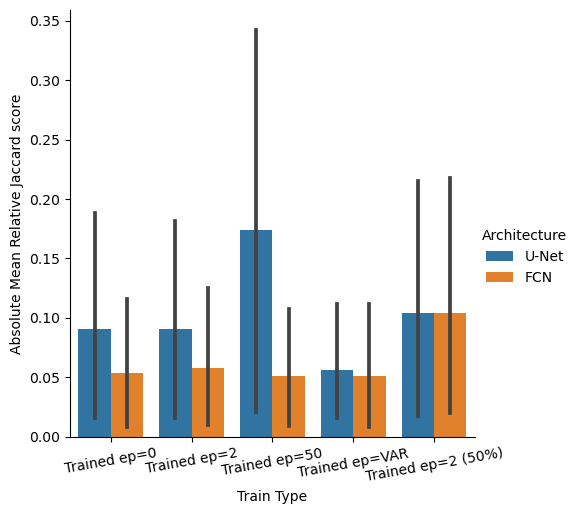

In [251]:
import seaborn as sns
sns.catplot(data=df, x="model", y="diff", hue="Architecture", kind="bar")
plt.ylabel('Absolute Mean Relative Jaccard score')
plt.xlabel('Train Type')
# plt.title('Perturbation Robustness')
plt.xticks(rotation=10)
plt.savefig('Results_robust_20233002.png', bbox_inches='tight')

In [113]:
fcnepVAR_preds_y[5]

array([[[[1],
         [1],
         [1],
         ...,
         [0],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [0],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [0],
         [1],
         [1]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[1],
         [1],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[1],
         [1],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[1],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],


In [ ]:
# Adding evalualtion of models

In [14]:
# UNET FOR EP=0

eval_result_unet_ep0_0 = unetep0.evaluate(newtest_unet_ep0_0, Y_test)
print("For ep @ 0 [test loss, test accuracy]:", eval_result_unet_ep0_0)

eval_result_unet_ep0_2 = unetep0.evaluate(newtest_unet_ep0_2, Y_test)
print("For ep @ 2 [test loss, test accuracy]:", eval_result_unet_ep0_2)

eval_result_unet_ep0_5 = unetep0.evaluate(newtest_unet_ep0_5, Y_test)
print("For ep @ 5 [test loss, test accuracy]:", eval_result_unet_ep0_5)

eval_result_unet_ep0_10 = unetep0.evaluate(newtest_unet_ep0_10, Y_test)
print("For ep @ 10 [test loss, test accuracy]:", eval_result_unet_ep0_10)

eval_result_unet_ep0_25 = unetep0.evaluate(newtest_unet_ep0_25, Y_test)
print("For ep @ 25 [test loss, test accuracy]:", eval_result_unet_ep0_25)

eval_result_unet_ep0_50 = unetep0.evaluate(newtest_unet_ep0_50, Y_test)
print("For ep @ 50 [test loss, test accuracy]:", eval_result_unet_ep0_50)


3/3 [==============================] - 1s 197ms/step - loss: 0.0967 - binary_io_u_1: 0.8560
For ep @ 0 [test loss, test accuracy]: [0.09668667614459991, 0.8560132384300232]
3/3 [==============================] - 1s 198ms/step - loss: 0.1066 - binary_io_u_1: 0.8411
For ep @ 2 [test loss, test accuracy]: [0.10658981651067734, 0.841101884841919]
3/3 [==============================] - 1s 193ms/step - loss: 0.1228 - binary_io_u_1: 0.8202
For ep @ 5 [test loss, test accuracy]: [0.12281521409749985, 0.8201875686645508]
3/3 [==============================] - 1s 193ms/step - loss: 0.1526 - binary_io_u_1: 0.7887
For ep @ 10 [test loss, test accuracy]: [0.15263114869594574, 0.7887160778045654]
3/3 [==============================] - 1s 191ms/step - loss: 0.2498 - binary_io_u_1: 0.7159
For ep @ 25 [test loss, test accuracy]: [0.2498338371515274, 0.715874195098877]
3/3 [==============================] - 1s 200ms/step - loss: 0.4078 - binary_io_u_1: 0.6362
For ep @ 50 [test loss, test accuracy]: [0.4

In [16]:
# UNET FOR EP=2

eval_result_unet_ep2_0 = unetep2.evaluate(newtest_unet_ep2_0, Y_test)
print("For ep @ 0 [test loss, test accuracy]:", eval_result_unet_ep2_0)

eval_result_unet_ep2_2 = unetep2.evaluate(newtest_unet_ep2_2, Y_test)
print("For ep @ 2 [test loss, test accuracy]:", eval_result_unet_ep2_2)

eval_result_unet_ep2_5 = unetep2.evaluate(newtest_unet_ep2_5, Y_test)
print("For ep @ 5 [test loss, test accuracy]:", eval_result_unet_ep2_5)

eval_result_unet_ep2_10 = unetep2.evaluate(newtest_unet_ep2_10, Y_test)
print("For ep @ 10 [test loss, test accuracy]:", eval_result_unet_ep2_10)

eval_result_unet_ep2_25 = unetep2.evaluate(newtest_unet_ep2_25, Y_test)
print("For ep @ 25 [test loss, test accuracy]:", eval_result_unet_ep2_25)

eval_result_unet_ep2_50 = unetep2.evaluate(newtest_unet_ep2_50, Y_test)
print("For ep @ 50 [test loss, test accuracy]:", eval_result_unet_ep2_50)



3/3 [==============================] - 1s 200ms/step - loss: 0.1231 - binary_io_u_2: 0.8279
For ep @ 0 [test loss, test accuracy]: [0.12305117398500443, 0.8278522491455078]
3/3 [==============================] - 1s 193ms/step - loss: 0.1326 - binary_io_u_2: 0.8166
For ep @ 2 [test loss, test accuracy]: [0.1325577199459076, 0.8165807723999023]
3/3 [==============================] - 1s 197ms/step - loss: 0.1449 - binary_io_u_2: 0.8029
For ep @ 5 [test loss, test accuracy]: [0.14486978948116302, 0.8028928637504578]
3/3 [==============================] - 1s 192ms/step - loss: 0.1636 - binary_io_u_2: 0.7839
For ep @ 10 [test loss, test accuracy]: [0.16362066566944122, 0.7839475870132446]
3/3 [==============================] - 1s 201ms/step - loss: 0.2150 - binary_io_u_2: 0.7404
For ep @ 25 [test loss, test accuracy]: [0.21499967575073242, 0.7404482364654541]
3/3 [==============================] - 1s 193ms/step - loss: 0.2989 - binary_io_u_2: 0.6861
For ep @ 50 [test loss, test accuracy]: [0

In [17]:
# UNET FOR EP=50

eval_result_unet_ep50_0 = unetep50.evaluate(newtest_unet_ep50_0, Y_test)
print("For ep @ 0 [test loss, test accuracy]:", eval_result_unet_ep50_0)

eval_result_unet_ep50_2 = unetep50.evaluate(newtest_unet_ep50_2, Y_test)
print("For ep @ 2 [test loss, test accuracy]:", eval_result_unet_ep50_2)

eval_result_unet_ep50_5 = unetep50.evaluate(newtest_unet_ep50_5, Y_test)
print("For ep @ 5 [test loss, test accuracy]:", eval_result_unet_ep50_5)

eval_result_unet_ep50_10 = unetep50.evaluate(newtest_unet_ep50_10, Y_test)
print("For ep @ 10 [test loss, test accuracy]:", eval_result_unet_ep50_10)

eval_result_unet_ep50_25 = unetep50.evaluate(newtest_unet_ep50_25, Y_test)
print("For ep @ 25 [test loss, test accuracy]:", eval_result_unet_ep50_25)

eval_result_unet_ep50_50 = unetep50.evaluate(newtest_unet_ep50_50, Y_test)
print("For ep @ 50 [test loss, test accuracy]:", eval_result_unet_ep50_50)


3/3 [==============================] - 1s 196ms/step - loss: 0.1050 - binary_io_u_1: 0.8522
For ep @ 0 [test loss, test accuracy]: [0.10501405596733093, 0.8521907329559326]
3/3 [==============================] - 1s 208ms/step - loss: 0.1128 - binary_io_u_1: 0.8416
For ep @ 2 [test loss, test accuracy]: [0.11284594237804413, 0.8415986895561218]
3/3 [==============================] - 1s 202ms/step - loss: 0.1259 - binary_io_u_1: 0.8257
For ep @ 5 [test loss, test accuracy]: [0.12589578330516815, 0.8257136344909668]
3/3 [==============================] - 1s 197ms/step - loss: 0.1510 - binary_io_u_1: 0.7999
For ep @ 10 [test loss, test accuracy]: [0.15102426707744598, 0.7998797297477722]
3/3 [==============================] - 1s 195ms/step - loss: 0.2450 - binary_io_u_1: 0.7316
For ep @ 25 [test loss, test accuracy]: [0.2449544072151184, 0.7315645217895508]
3/3 [==============================] - 1s 195ms/step - loss: 0.4717 - binary_io_u_1: 0.5695
For ep @ 50 [test loss, test accuracy]: [0

In [26]:
# UNET FOR EP=VAR

eval_result_unet_epVAR_0 = unetepVAR.evaluate(newtest_unet_epVAR_0, Y_test)
print("For ep @ 0 [test loss, test accuracy]:", eval_result_unet_epVAR_0)

eval_result_unet_epVAR_2 = unetepVAR.evaluate(newtest_unet_epVAR_2, Y_test)
print("For ep @ 2 [test loss, test accuracy]:", eval_result_unet_epVAR_2)

eval_result_unet_epVAR_5 = unetepVAR.evaluate(newtest_unet_epVAR_5, Y_test)
print("For ep @ 5 [test loss, test accuracy]:", eval_result_unet_epVAR_5)

eval_result_unet_epVAR_10 = unetepVAR.evaluate(newtest_unet_epVAR_10, Y_test)
print("For ep @ 10 [test loss, test accuracy]:", eval_result_unet_epVAR_10)

eval_result_unet_epVAR_25 = unetepVAR.evaluate(newtest_unet_epVAR_25, Y_test)
print("For ep @ 25 [test loss, test accuracy]:", eval_result_unet_epVAR_25)

eval_result_unet_epVAR_50 = unetepVAR.evaluate(newtest_unet_epVAR_50, Y_test)
print("For ep @ 50 [test loss, test accuracy]:", eval_result_unet_epVAR_50)


3/3 [==============================] - 1s 201ms/step - loss: 0.0984 - binary_io_u_1: 0.8614
For ep @ 0 [test loss, test accuracy]: [0.09835413843393326, 0.8614226579666138]
3/3 [==============================] - 1s 197ms/step - loss: 0.1070 - binary_io_u_1: 0.8496
For ep @ 2 [test loss, test accuracy]: [0.10696326196193695, 0.8496096134185791]
3/3 [==============================] - 1s 195ms/step - loss: 0.1213 - binary_io_u_1: 0.8328
For ep @ 5 [test loss, test accuracy]: [0.12132183462381363, 0.8328264355659485]
3/3 [==============================] - 1s 196ms/step - loss: 0.1488 - binary_io_u_1: 0.8054
For ep @ 10 [test loss, test accuracy]: [0.14882662892341614, 0.805448055267334]
3/3 [==============================] - 1s 196ms/step - loss: 0.2483 - binary_io_u_1: 0.7318
For ep @ 25 [test loss, test accuracy]: [0.24834094941616058, 0.731787919998169]
3/3 [==============================] - 1s 193ms/step - loss: 0.4369 - binary_io_u_1: 0.6226
For ep @ 50 [test loss, test accuracy]: [0.

In [18]:
# FCN FOR EP=0

eval_result_fcn_ep0_0 = fcnep0.evaluate(newtest_fcn_ep0_0, Y_test)
print("For ep @ 0 [test loss, test accuracy]:", eval_result_fcn_ep0_0)

eval_result_fcn_ep0_2 = fcnep0.evaluate(newtest_fcn_ep0_2, Y_test)
print("For ep @ 2 [test loss, test accuracy]:", eval_result_fcn_ep0_2)

eval_result_fcn_ep0_5 = fcnep0.evaluate(newtest_fcn_ep0_5, Y_test)
print("For ep @ 5 [test loss, test accuracy]:", eval_result_fcn_ep0_5)

eval_result_fcn_ep0_10 = fcnep0.evaluate(newtest_fcn_ep0_10, Y_test)
print("For ep @ 10 [test loss, test accuracy]:", eval_result_fcn_ep0_10)

eval_result_fcn_ep0_25 = fcnep0.evaluate(newtest_fcn_ep0_25, Y_test)
print("For ep @ 25 [test loss, test accuracy]:", eval_result_fcn_ep0_25)

eval_result_fcn_ep0_50 = fcnep0.evaluate(newtest_fcn_ep0_50, Y_test)
print("For ep @ 50 [test loss, test accuracy]:", eval_result_fcn_ep0_50)



3/3 [==============================] - 0s 37ms/step - loss: 0.2196 - binary_io_u_2: 0.7711
For ep @ 0 [test loss, test accuracy]: [0.2195645123720169, 0.7710857391357422]
3/3 [==============================] - 0s 36ms/step - loss: 0.2247 - binary_io_u_2: 0.7634
For ep @ 2 [test loss, test accuracy]: [0.2246786653995514, 0.7633770704269409]
3/3 [==============================] - 0s 38ms/step - loss: 0.2338 - binary_io_u_2: 0.7468
For ep @ 5 [test loss, test accuracy]: [0.23383212089538574, 0.7467623949050903]
3/3 [==============================] - 0s 36ms/step - loss: 0.2554 - binary_io_u_2: 0.7309
For ep @ 10 [test loss, test accuracy]: [0.25540369749069214, 0.7309051752090454]
3/3 [==============================] - 0s 36ms/step - loss: 0.3383 - binary_io_u_2: 0.6476
For ep @ 25 [test loss, test accuracy]: [0.33832836151123047, 0.6475975513458252]
3/3 [==============================] - 0s 36ms/step - loss: 0.5725 - binary_io_u_2: 0.3179
For ep @ 50 [test loss, test accuracy]: [0.572484

In [19]:
# FCN FOR EP=2

eval_result_fcn_ep2_0 = fcnep2.evaluate(newtest_fcn_ep2_0, Y_test)
print("For ep @ 0 [test loss, test accuracy]:", eval_result_fcn_ep2_0)

eval_result_fcn_ep2_2 = fcnep2.evaluate(newtest_fcn_ep2_2, Y_test)
print("For ep @ 2 [test loss, test accuracy]:", eval_result_fcn_ep2_2)

eval_result_fcn_ep2_5 = fcnep2.evaluate(newtest_fcn_ep2_5, Y_test)
print("For ep @ 5 [test loss, test accuracy]:", eval_result_fcn_ep2_5)

eval_result_fcn_ep2_10 = fcnep2.evaluate(newtest_fcn_ep2_10, Y_test)
print("For ep @ 10 [test loss, test accuracy]:", eval_result_fcn_ep2_10)

eval_result_fcn_ep2_25 = fcnep2.evaluate(newtest_fcn_ep2_25, Y_test)
print("For ep @ 25 [test loss,test accuracy]:", eval_result_fcn_ep2_25)

eval_result_fcn_ep2_50 = fcnep2.evaluate(newtest_fcn_ep2_50, Y_test)
print("For ep @ 50 [test loss, test accuracy]:", eval_result_fcn_ep2_50)


3/3 [==============================] - 0s 36ms/step - loss: 0.2242 - binary_io_u_1: 0.7540
For ep @ 0 [test loss, test accuracy]: [0.22416311502456665, 0.7539718151092529]
3/3 [==============================] - 0s 37ms/step - loss: 0.2295 - binary_io_u_1: 0.7471
For ep @ 2 [test loss, test accuracy]: [0.22954344749450684, 0.7471290826797485]
3/3 [==============================] - 0s 36ms/step - loss: 0.2383 - binary_io_u_1: 0.7284
For ep @ 5 [test loss, test accuracy]: [0.23830394446849823, 0.7283684611320496]
3/3 [==============================] - 0s 36ms/step - loss: 0.2547 - binary_io_u_1: 0.7074
For ep @ 10 [test loss, test accuracy]: [0.25468316674232483, 0.7074316740036011]
3/3 [==============================] - 0s 37ms/step - loss: 0.3227 - binary_io_u_1: 0.6174
For ep @ 25 [test loss,test accuracy]: [0.32274001836776733, 0.6174424886703491]
3/3 [==============================] - 0s 36ms/step - loss: 0.5344 - binary_io_u_1: 0.4011
For ep @ 50 [test loss, test accuracy]: [0.53441

In [20]:
# FCN FOR EP=50

eval_result_fcn_ep50_0 = fcnep50.evaluate(newtest_fcn_ep50_0, Y_test)
print("For ep @ 0 [test loss, test accuracy]:", eval_result_fcn_ep50_0)

eval_result_fcn_ep50_2 = fcnep50.evaluate(newtest_fcn_ep50_2, Y_test)
print("For ep @ 2 [test loss, test accuracy]:", eval_result_fcn_ep50_2)

eval_result_fcn_ep50_5 = fcnep50.evaluate(newtest_fcn_ep50_5, Y_test)
print("For ep @ 5 [test loss, test accuracy]:", eval_result_fcn_ep50_5)

eval_result_fcn_ep50_10 = fcnep50.evaluate(newtest_fcn_ep50_10, Y_test)
print("For ep @ 10 [test loss, test accuracy]:", eval_result_fcn_ep50_10)

eval_result_fcn_ep50_25 = fcnep50.evaluate(newtest_fcn_ep50_25, Y_test)
print("For ep @ 25 [test loss,test accuracy]:", eval_result_fcn_ep50_25)

eval_result_fcn_ep50_50 = fcnep50.evaluate(newtest_fcn_ep50_50, Y_test)
print("For ep @ 50 [test loss, test accuracy]:", eval_result_fcn_ep50_50)


3/3 [==============================] - 0s 38ms/step - loss: 0.5057 - binary_io_u_2: 0.4191
For ep @ 0 [test loss, test accuracy]: [0.5057265162467957, 0.41910427808761597]
3/3 [==============================] - 0s 37ms/step - loss: 0.5666 - binary_io_u_2: 0.3824
For ep @ 2 [test loss, test accuracy]: [0.5666430592536926, 0.38241851329803467]
3/3 [==============================] - 0s 37ms/step - loss: 0.7421 - binary_io_u_2: 0.3536
For ep @ 5 [test loss, test accuracy]: [0.7420618534088135, 0.3536241948604584]
3/3 [==============================] - 0s 35ms/step - loss: 1.0931 - binary_io_u_2: 0.3538
For ep @ 10 [test loss, test accuracy]: [1.0930593013763428, 0.3537988066673279]
3/3 [==============================] - 0s 36ms/step - loss: 2.1876 - binary_io_u_2: 0.3337
For ep @ 25 [test loss,test accuracy]: [2.1876091957092285, 0.3337341248989105]
3/3 [==============================] - 0s 36ms/step - loss: 4.9739 - binary_io_u_2: 0.2990
For ep @ 50 [test loss, test accuracy]: [4.97385263

In [21]:
# FCN FOR EP=VAR

eval_result_fcn_epVAR_0 = fcnepVAR.evaluate(newtest_fcn_epVAR_0, Y_test)
print("For ep @ 0 [test loss, test accuracy]:", eval_result_fcn_epVAR_0)

eval_result_fcn_epVAR_2 = fcnepVAR.evaluate(newtest_fcn_epVAR_2, Y_test)
print("For ep @ 2 [test loss, test accuracy]:", eval_result_fcn_epVAR_2)

eval_result_fcn_epVAR_5 = fcnepVAR.evaluate(newtest_fcn_epVAR_5, Y_test)
print("For ep @ 5 [test loss, test accuracy]:", eval_result_fcn_epVAR_5)

eval_result_fcn_epVAR_10 = fcnepVAR.evaluate(newtest_fcn_epVAR_10, Y_test)
print("For ep @ 10 [test loss, test accuracy]:", eval_result_fcn_epVAR_10)

eval_result_fcn_epVAR_25 = fcnepVAR.evaluate(newtest_fcn_epVAR_25, Y_test)
print("For ep @ 25 [test loss,test accuracy]:", eval_result_fcn_epVAR_25)

eval_result_fcn_epVAR_50 = fcnepVAR.evaluate(newtest_fcn_epVAR_50, Y_test)
print("For ep @ 50 [test loss, test accuracy]:", eval_result_fcn_epVAR_50)


3/3 [==============================] - 0s 36ms/step - loss: 0.1965 - binary_io_u_3: 0.7403
For ep @ 0 [test loss, test accuracy]: [0.19648417830467224, 0.7403141856193542]
3/3 [==============================] - 0s 37ms/step - loss: 0.2028 - binary_io_u_3: 0.7328
For ep @ 2 [test loss, test accuracy]: [0.20282189548015594, 0.7327988147735596]
3/3 [==============================] - 0s 36ms/step - loss: 0.2130 - binary_io_u_3: 0.7212
For ep @ 5 [test loss, test accuracy]: [0.21299897134304047, 0.7211930155754089]
3/3 [==============================] - 0s 38ms/step - loss: 0.2322 - binary_io_u_3: 0.6933
For ep @ 10 [test loss, test accuracy]: [0.23220869898796082, 0.6932622790336609]
3/3 [==============================] - 0s 40ms/step - loss: 0.3121 - binary_io_u_3: 0.6026
For ep @ 25 [test loss,test accuracy]: [0.31209638714790344, 0.6026307940483093]
3/3 [==============================] - 0s 36ms/step - loss: 0.6076 - binary_io_u_3: 0.4473
For ep @ 50 [test loss, test accuracy]: [0.60758

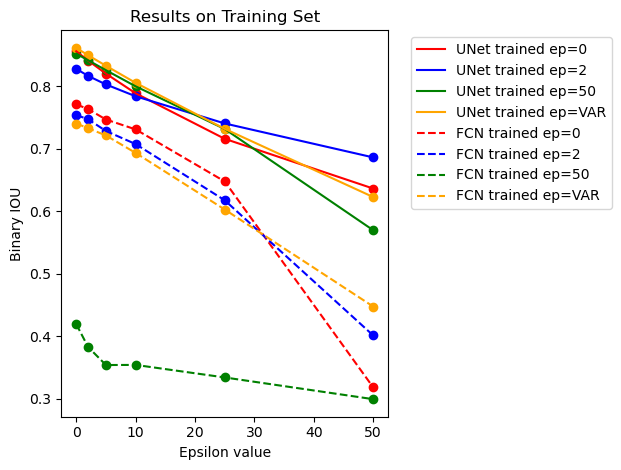

In [45]:
eps = [0, 2, 5, 10, 25, 50]
iou_unet_ep0 = [eval_result_unet_ep0_0[1], eval_result_unet_ep0_2[1], eval_result_unet_ep0_5[1], eval_result_unet_ep0_10[1], eval_result_unet_ep0_25[1], eval_result_unet_ep0_50[1]]
iou_unet_ep2 = [eval_result_unet_ep2_0[1], eval_result_unet_ep2_2[1], eval_result_unet_ep2_5[1], eval_result_unet_ep2_10[1], eval_result_unet_ep2_25[1], eval_result_unet_ep2_50[1]]
iou_unet_ep50 = [eval_result_unet_ep50_0[1], eval_result_unet_ep50_2[1], eval_result_unet_ep50_5[1], eval_result_unet_ep50_10[1], eval_result_unet_ep50_25[1], eval_result_unet_ep50_50[1]]
iou_unet_epVAR = [eval_result_unet_epVAR_0[1], eval_result_unet_epVAR_2[1], eval_result_unet_epVAR_5[1], eval_result_unet_epVAR_10[1], eval_result_unet_epVAR_25[1], eval_result_unet_epVAR_50[1]]

iou_fcn_ep0 = [eval_result_fcn_ep0_0[1], eval_result_fcn_ep0_2[1], eval_result_fcn_ep0_5[1], eval_result_fcn_ep0_10[1], eval_result_fcn_ep0_25[1], eval_result_fcn_ep0_50[1]]
iou_fcn_ep2 = [eval_result_fcn_ep2_0[1], eval_result_fcn_ep2_2[1], eval_result_fcn_ep2_5[1], eval_result_fcn_ep2_10[1], eval_result_fcn_ep2_25[1], eval_result_fcn_ep2_50[1]]
iou_fcn_ep50 = [eval_result_fcn_ep50_0[1], eval_result_fcn_ep50_2[1], eval_result_fcn_ep50_5[1], eval_result_fcn_ep50_10[1], eval_result_fcn_ep50_25[1], eval_result_fcn_ep50_50[1]]
iou_fcn_epVAR = [eval_result_fcn_epVAR_0[1], eval_result_fcn_epVAR_2[1], eval_result_fcn_epVAR_5[1], eval_result_fcn_epVAR_10[1], eval_result_fcn_epVAR_25[1], eval_result_fcn_epVAR_50[1]]



plt.scatter(eps, iou_unet_ep0, color = 'r')
plt.plot(eps, iou_unet_ep0, label="UNet trained ep=0", color = 'r')

plt.scatter(eps, iou_unet_ep2, color = 'b')
plt.plot(eps, iou_unet_ep2, label="UNet trained ep=2", color = 'b')

plt.scatter(eps, iou_unet_ep50, color = 'green')
plt.plot(eps, iou_unet_ep50, label="UNet trained ep=50", color = 'green')

plt.scatter(eps, iou_unet_epVAR, color = 'orange')
plt.plot(eps, iou_unet_epVAR, label="UNet trained ep=VAR", color = 'orange')

plt.scatter(eps, iou_fcn_ep0, color = 'r')
plt.plot(eps, iou_fcn_ep0, label="FCN trained ep=0", color = 'r', linestyle='dashed')

plt.scatter(eps, iou_fcn_ep2, color = 'b')
plt.plot(eps, iou_fcn_ep2, label="FCN trained ep=2", color = 'b', linestyle='dashed')

plt.scatter(eps, iou_fcn_ep50, color = 'g')
plt.plot(eps, iou_fcn_ep50, label="FCN trained ep=50", color = 'g', linestyle='dashed')

plt.scatter(eps, iou_fcn_epVAR, color = 'orange')
plt.plot(eps, iou_fcn_epVAR, label="FCN trained ep=VAR", color = 'orange', linestyle='dashed')


plt.xlabel('Epsilon value')
plt.ylabel('Binary IOU')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Results on Training Set")
plt.tight_layout()

plt.savefig('UNETresults.png')
